In [1]:
import arviz as az
import bambi as bmb
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
%matplotlib inline
plt.style.use("intuitivebayes.mplstyle")

mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.spines.left"] = False
FIGSIZE = (12, 7)

# Section 10: Introduction

In this lesson, we'll imagine we are working in the data science team of an e-commerce company. In particular, we sell really good and fresh fish to our clients (mainly fancy restaurants).

Wait a moment... We already heard this story in the past!


## The inference loop

<center>
  <img src="imgs/model_development.png" style="width:50%"; />
</center>

And it's true! We're going to recycle the setting from the previous lesson. And it's for a very good reason!

In the previous lesson, we worked following these steps:

Today, we're focusing on Model development only, because we're learning how to use a fantastic new tool: Bambi


<p style="color:green">We could include a slide with the Bambi logo here when you say Bambi! or have Fadi animate it onto the screen.
    
    
 My preference is to add a static slide thats hidden so folks who download this notebook see it, but in the video we have have it "slap down" onto the screen with animation because thats more exciting
    
On another note. This section needs to be expanded to include summaries of each.</p>



# Section 20: The world's simplest model, now simpler

## First things first

In [3]:
data = pd.read_csv("data/fish-market.csv")
data = data[data["Weight"] > 0].reset_index(drop=True)
data

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
153,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
154,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
155,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
156,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


Let's quickly load the data frame and remove the observation with the null weight.

## The model

$$
\begin{aligned}
\text{Weight}_i &= \beta_0 + \varepsilon_i \\
\varepsilon_i & \sim \text{Normal}(0, \sigma) 
\end{aligned}
$$

In [4]:
model = bmb.Model("Weight ~ 1", data)

Let's create the intercept only model using Bambi. As you can see, it fits in a single line. We only need to pass a formula describing the model and the data frame that contains the data. We'll come back to the details in just a moment. 

## Fit the model

In [5]:
idata = model.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, Weight_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


Is that simple? Yes, it's that simple. 

It's really cool! For those of you who are fans of the scikit-learn API, Bambi brings it back for you.

And that's not all! And that's not all! Don't you see anything familiar in the sampler message? I bet you do. After all, Bambi creates a PyMC model under the hood. So whenever we fit a Bambi model, we're actually fitting a PyMC one.

## What's in the returned object?

In [6]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In the previous lesson, we learned how to work with the `InferenceData` object PyMC gives back. Do we need to learn how to work with a new object type? Of course not!

Bambi also returns an `InferenceData` object. It contains similar information to the `InferenceData` objects we obtained when working with PyMC models directly. 

By default, we have the following groups:

* `posterior`: Draws from the posterior distribution.
* `log_likelihood`: The log likelihood evaluated at every draw of the posterior. Useful for model comparison.
* `sample_stats`: Statistics of the sampler. Useful for diagnostics.
* `observed_data`: The fish weights.

For now, the `posterior` group is our main focus.

## The posterior

In [7]:
idata.posterior

<xarray.Dataset>
Dimensions:       (chain: 2, draw: 1000)
Coordinates:
  * chain         (chain) int64 0 1
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    Intercept     (chain, draw) float64 412.9 399.7 415.4 ... 394.3 378.1 383.7
    Weight_sigma  (chain, draw) float64 359.6 361.8 353.1 ... 370.8 370.1 370.3
Attributes:
    created_at:                  2022-11-30T02:13:04.417360
    arviz_version:               0.12.1
    inference_library:           pymc
    inference_library_version:   4.1.5
    sampling_time:               3.9799485206604004
    tuning_steps:                1000
    modeling_interface:          bambi
    modeling_interface_version:  0.9.1

The intercept only model in distributional form...

$$
\begin{aligned}
\beta_0 & \sim \text{Normal}(0, \sigma_{\beta_0}) \\
\sigma & \sim \text{HalfNormal}(\sigma_\varepsilon) \\
\text{Weight}_i & \sim \text{Normal}(\beta_0, \sigma) 
\end{aligned}
$$

There are two parameters: one called `Intercept` and other called `Weight_sigma`. If we have a look at the distributional representation of the model we wrote in the previous lesson, we can see they match $\beta_0$ and $\sigma$, the two parameters that are random in the model.

**Edition note:** Add text pointing to the different coefficients. "Intercept" pointing to "beta_0" and "Weight_sigma" pointing to "sigma".

## It's InferenceData you know

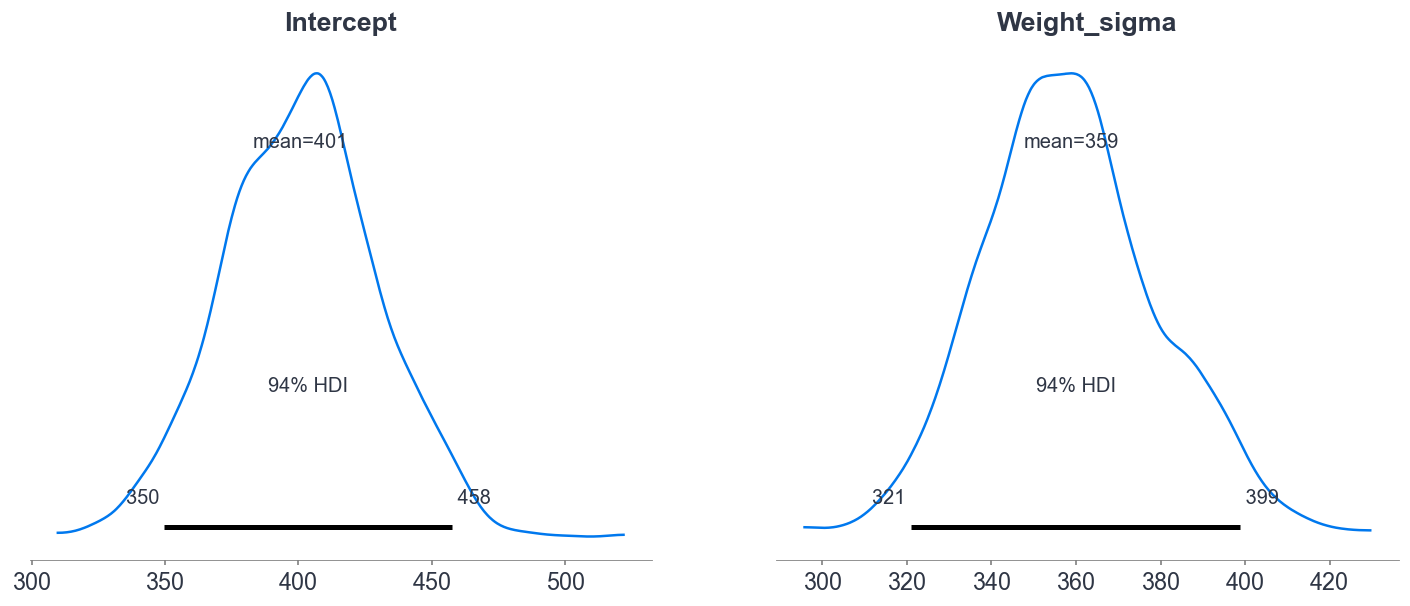

In [8]:
az.plot_posterior(idata);

All `InferenceData`s are ArviZ friendly. We can use all the ArviZ functions we love using with PyMC models with our brand-new Bambi models. It's the same type of object, so we can expect to be able to do the same.

For example, we can explore the posteriors using `az.plot_posterior`. Does the plot look familiar? Does it match the values we got in our previous lesson? 

* The posterior of the `Intercept` is very similar. It's centered around a similar value, but it's just a little wider
* The posterior of `Weight_sigma` is around larger values. Since both models are the same and use the same data, it must be that the priors we had for the PyMC model were tighter than the priors here.

## What did we do?

Not much... 😜

* We wrote a single line of code
* We created a Bambi model

<center>
  <img src="imgs/model_definition_basics.png" style="width:50%"; />
</center>

The very basics of a Bambi model are

* A model formula
    * Specifies the response and the predictors
* A data frame
    * Where to extract variables from

## How formulas are translated to models

<center>
  <img src="imgs/formula_1.png" style="width:40%"; />
</center>

The model formula is a concise and clear representation of the response and the predictors of a statistical model. One of it's main characteristics is the tilde operator (`~`), which separates the response from the predictors. Anything on left hand side is part of the response, and anything on the right hand side is part of the predictors.

* Each of these sides consists one or more **terms**. 
* Terms are (usually) separated by the plus symbol `+`
* `Weight` on the left-hand side is the response term
* `1` on the right-hand side is the only predictor term

In this lesson we're going to cover many details about the predictors part of the formula. And you know what? We have already covered something special! The `1` on the right hand side is not the name of any of the variables we have, right? However, this is how you tell Bambi that you want your model to have an intercept.

Here's a helpful trick to understanding why the `1` is used to represent the intercept: think of the intercept as a slope parameter that is multiplied by a a predictor that is always equal to 1. In the end, multiplying a coefficient by 1 is not going to change it. And that's exactly what happens with the intercept. 

To gain a better understanding of how model formulas translate into statistical models, we'll be seeing diagrams like this one along the entire lesson. You have my word!

## Comparison with PyMC

In [9]:
with pm.Model() as pm_model:
    intercept = pm.Normal("Intercept", sigma=200)
    sigma = pm.HalfNormal("sigma", sigma=100)
    pm.Normal("Weight", mu=intercept, sigma=sigma, observed=data["Weight"])

In [10]:
bmb_model = bmb.Model("Weight ~ 1", data)

Here we have two model implementations, side by side. Statistically speaking, they're the same model. But in terms of implementation cost, there's a huge difference! While the PyMC model takes 4 lines and PyMC: 4 lines and ~ 200 characters, the Bambi model takes 1 line and ~ 40 characters. That's pretty impressive, huh?

## Should I use Bambi or PyMC? RK added
**Insert picture of both tools logos**

But now you may be asking which one should I use?

## Our suggestions
If you're 
* Working outside of linear regression
* Need more fine tuned control of models
* Are the type of person that prefers writing things down yourself

Use PyMC

* Need to specify models quickly
* Prefer terser syntax
* Working with colleagues that use tools like BRMS often

Use Bambi




In this block add 

## In this course we'll learn both

**Take previous silde and put a box around both

Because we're learning we're goingn to show you both in this class. This way you learn exactly what's happening in every model, and so you're the most informed moving forward for whatever life throws at you. If you find yourself needing to make 20 regressions in one day you'll be able to knock that out with Bambi. But if you find yourself needing to put a logistic regression into a complex GP model which will require PyMC, you'll know how to do that too. Well if you decide to also take the GP course!

**Note:** Pretty impressive gif?

## Section Recap

* We introduced Bambi 🦌
* Bambi models are made of two basic components
    * A formula
    * A data frame
* Bambi creates a PyMC model internally
* Some benefits of working with Bambi
    * Provides a concise syntax
    * Handles all the complexities automatically
        * Is less error prone
        * Allows faster iteration


<p style="color:green">Dont say some benefits. Be more forceful and direct  </p>


Bambi takes care of all the complicated internal details.

## Section Recap

* We introduced Bambi 🦌
* Benefits of working with Bambi
    * Provides a concise syntax
    * Handles all the complexities automatically
        * Is less error prone in a full workflow
        * Allows faster iteration
* Bambi models are specified using two basic components
    * A formula that specifies the likelihood and parameters
    * A dataframe that contains the data
* Under the ehood Bambi creates a PyMC model internally
  * Bambi automatically determine data types, priors and other details lettings you focus on the data and issue at hand


# Section 30: What's in a Bambi model

In the previous section we saw veeery easy to create models with Bambi. But, being completely honest, we know between nothing and very little about the details. 

The goal of this section is to get more familiar with the components of a Bambi model so we can feel more comfortable when working with them. This is our first step to get from zero to hero. We'll learn what are the most important parts in a Bambi model, how to access them, and how Bambi uses them internally. We have a lot ahead of us, let's jump into it!

<p style="color:green">This section is like a dish that needs some more spice. Its not bad but its missing something.

Right now this section is just telling peope whats in a bambi model which is fine lacking anything actionable.
    
    I'm still thinking through it but heres my quick thoughts. We need to be more forward about why people care.
    Instead of focusing on what bambi is and whats in it maybe the tone here is
    
    In the last section we showed you that Bambi made model creation easy, were not goign to show you how to get ec
    
    
    
    The takeaway then isnt "this is whats in bambi", but then more along the lines of "This is **how** you can insect the model yourself.
    
    P.S i'm happy to take a stab at rearranging this if you like

</p>


## Is Bambi a Bayesian library?

* Bayes in a nutshell: Update prior knowledge with data to obtain posterior knowledge

* Where are the priors in Bambi?

* Bambi provides automatic priors

* Benefits:
    * Faster prototyping
    * Faster iteration
    * Easier to learn

First things first. We created a model and that's great. But if Bambi is a Bayesian library, there must be priors somewhere. And we never wrote them down. I feels like cheating. Why is that? Is it because Bambi is not Bayesian? 

The answer is... Bambi is Bayesian. But it provides automatic priors so you it's not strictly required to tell it the priors manually. This is a huge topic itself, so this section will show you only the basics. More advanced stuff is going to be covered in much more in an appendix in the end of the lesson. For now, it's good to know that Bambi does follow the Bayesian approach, but it just makes things a little easier for us so we can iterate faster, writing less code and not having to deal with piors at very early stages. Obviously, once we get to use it more seriously, it will be good to specify our own priors.

**Pssst:** Bambi does not remove the problem of working with priors. We still must take care of priors in any serious work! 

**Note** Make this a slide with an image?

## The Printing Revolution

<center>
  <img src="imgs/PrintingRevolution.jpg" style="width:75%"; />
</center>

<!-- To give attribution: https://en.wikipedia.org/wiki/Printing_press#/media/File:Chodowiecki_Basedow_Tafel_21_c_Z.jpg -->

The printing press was invented around 1440 in the Roman Empire by Johannes Gutenberg. This new tool enabled the communication of ideas and the sharing of knowledge on an unprecedented scale... And we could keep saying so many things about one of the most important inventions of humankind. But how does it connect to what we're doing here?!

Oh, yes! One of the most accesible ways to see what's in a Bambi model is to print it!

<p style="color:green">This is really good Tomas! I love it. We can even add a note that it allowed for more ideas to be shared through automation and reduction of labor? Doesnt this sound like what Bambi does too?</p>


## The (Bambi) Printing Revolution

In [11]:
model = bmb.Model("Weight ~ 1", data)

In [12]:
print(model)

Formula: Weight ~ 1
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 400.8475, sigma: 891.4101)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 356.564)


Previously, we created an intercept-only regression model using Bambi. We saw it was a very concise piece of code. Fitting the model was also very easy. But there's something even cooler. When we print a Bambi model, it gives us a lot of information. 

From now, we're going to have a look at and digest the information shown to us, one at a time.

## The formula

In [13]:
model # hide this cell

Formula: Weight ~ 1
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 400.8475, sigma: 891.4101)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 356.564)

The first thing we have is the model formula. We can see it as a reminder of the formula that was used to create the model. If you've just created the model one cell above it's not of much value. But it becomes really useful when you have more than a single model in a large Jupyter Notebook and you want to make sure what's in each of them.

**Edition note:** Higlight the part we're talking about in each slide.

## The family

In [14]:
model # hide this cell

Formula: Weight ~ 1
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 400.8475, sigma: 891.4101)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 356.564)

Families are a broad thing in Bambi that represents the type of the model we're working with. Shortly, families connect a couple of definitions that altogether define a unique statistical model. We're going to see this so many times from now. In the meantime, we're happy to see it says `"gaussian"`. It's telling us the model is using a Gaussian likelihood function. 

But this is not magic! It's not happening because Bambi is smart enough to read our minds, or has used an AI-powered tool to watch our previous lesson! It's usually way simpler. In this case, since Gaussian linear regressions are so popular, the `"gaussian"` family is the default choice. 

We're going to cover several examples where we use non-default families in the following lessons. I bet you'll become a pro!

## The link

In [15]:
model # hide this cell

Formula: Weight ~ 1
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 400.8475, sigma: 891.4101)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 356.564)

Similarly to families, links, or link functions, is a key concept. Again, we will not cover in depth in this lesson. In some part it's because such a big topic deserves proper attention, and in other part because it's already very well covered in Lesson 4 -- when it's actually used.

In a nutshell, a link is a function (aka transformation) that is applied to the mean of the likelihood function. It may sound complicated, but trust me, Lesson 4 will shed light on this. 

For now, we're happy to see it says `"identity"`. It means it doesn't change anything -- because it applies the identity function!

## Observations

In [16]:
model # hide this cell

Formula: Weight ~ 1
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 400.8475, sigma: 891.4101)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 356.564)

No matter which paradigm we use to build our models, there's something all of us need: data! In Bambi we use the word "observation" to represent each unit in the dataset, and it assumes that every row in the dataset is an observation.

Bambi always tells you how many observations entered the model. In some cases, like when there are missing values, it's possible the number of observations being usied is smaller than the number of rows in the dataset. And this feature is very useful in those cases! On top of that, it allows to quickly check the number of observations in all cases without having to look back into the original data frame.

## Priors

In [17]:
model # hide this cell

Formula: Weight ~ 1
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 400.8475, sigma: 891.4101)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 356.564)

And finally, hell yes, the priors! 

The first thing we can see is priors come in different groups. There it says "Common-level effects" and "Auxiliary parameters". These groups have a well defined purpose but it's too early to learn about such an advanced topic. But of course, they are very well covered later. What we need to learn now is that whenever we want to check what are the priors in the model, we can print it, and Bambi is going to show us the priors.

The most important things are

* The prior for the `Intercept` is a Normal distribution centered around 400, and sigma equals to 891.
* The prior for `sigma`, the standard deviation of the error term, is a `HalfStudenT` distribution with `nu` equals to 4 and sigma equals to 356.

These values were determined **automatically** by Bambi.

How Bambi chooses priors is a very interesting topic, and there's so much work behind it. This is covered in the appendix that you can find in the end of the Lesson.

<p style="color:green">What we can do here is add the PyMC model, and then highlight each of these in code the code to show the various pieces of bambi  </p>


## Section Recap

* Bambi models contain so much information
* Printing a model gives a great summary of it
* The most important pieces of a model are
    * The formula
    * The family
    * The link function
    * The number of observations
    * The priors

# Section 40: Adding Slopes

<p style="color:green">I stopped here </p>


In this section we're going to create the model that uses the length of the fish as a predictor. As we saw in the previous lesson, we'd better log-transform the `Weight` and the `Length1` if we want linear regression to work well here. 

## Prepare the data

In [18]:
data["log_weight"] = np.log(data["Weight"])
data["log_length"] = np.log(data["Length1"])

Bambi is great. It allows us to write models with a simple formula. But variable names must exist in the data frame where variables are taken from. Unfortunately, it only contains the unstransformed variables. So the transformation adds an extra step. Before creating the model, we need to compute the logarithm of the weight and the logarithm of the length and store them as new columns. Then we're ready to go!

## Create the model

In [19]:
model = bmb.Model("log_weight ~ 1 + log_length", data)
model

Formula: log_weight ~ 1 + log_length
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 5.41, sigma: 26.3354)
    log_length ~ Normal(mu: 0, sigma: 8.1834)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1.322)

Next, we create the model. Since `log_length` is part of the predictors, it goes on the right-hand side of the tilde `~`. See we have two predictor terms now, `1` anad `log_length`, glued with the plus symbol `+`.

The model summary is similar than before, but now it also shows the updated formula and the prior for `log_length`. Automatically, Bambi is using a Normal prior with mean 0 and standard deviation 8.18 for the slope parameter.

## A promise is a promise: more diagrams

<center>
  <img src="imgs/formula_1_plus_log_length.png" style="width:60%"; />
</center>

The model formula got just a little more complicated. As response, we have the `log_weight`. This is the transformed variable, and this is way it maps to the mean of the `log(Weight)`, because we're modeling the log-transformed variable. As predictors, we have two terms now. 

* `1`: always maps to the `Intercept` parameter, represented with $\beta_0$ above
* `log_length`: asks to include the logarithm of the length as a predictor
    * Since it's numeric, Bambi adds a slope $\beta_1$ that multiples the predictor `log_length`
    * The dashed line around the rectangle means it represents observed data 

## Build the model

In [20]:
model.build()

A natural step after creating the model is to fit it. We all love doing that! But now I would like to tell you a little more about the details. This is not essential for a basic practitioner, but if you want to become a real pro, it's better to learn them!

The construction of a Bambi model has two steps. 

* Creation of the Bambi model
* Creation of the underlying PyMC model

The first step occurs when we create the model with `bmb.Model()`. The second step can occur implicitly or explicitly. If we call `model.fit()`, the PyMC model is going be built implicitly, right before the sampling process starts. But sometimes we want to get other results for which the PyMC model is needed, like creating a plot of the priors or a graphi of the model, before actually fitting the model. For all those cases, we can build the PyMC model explicitly.

## Explore the priors

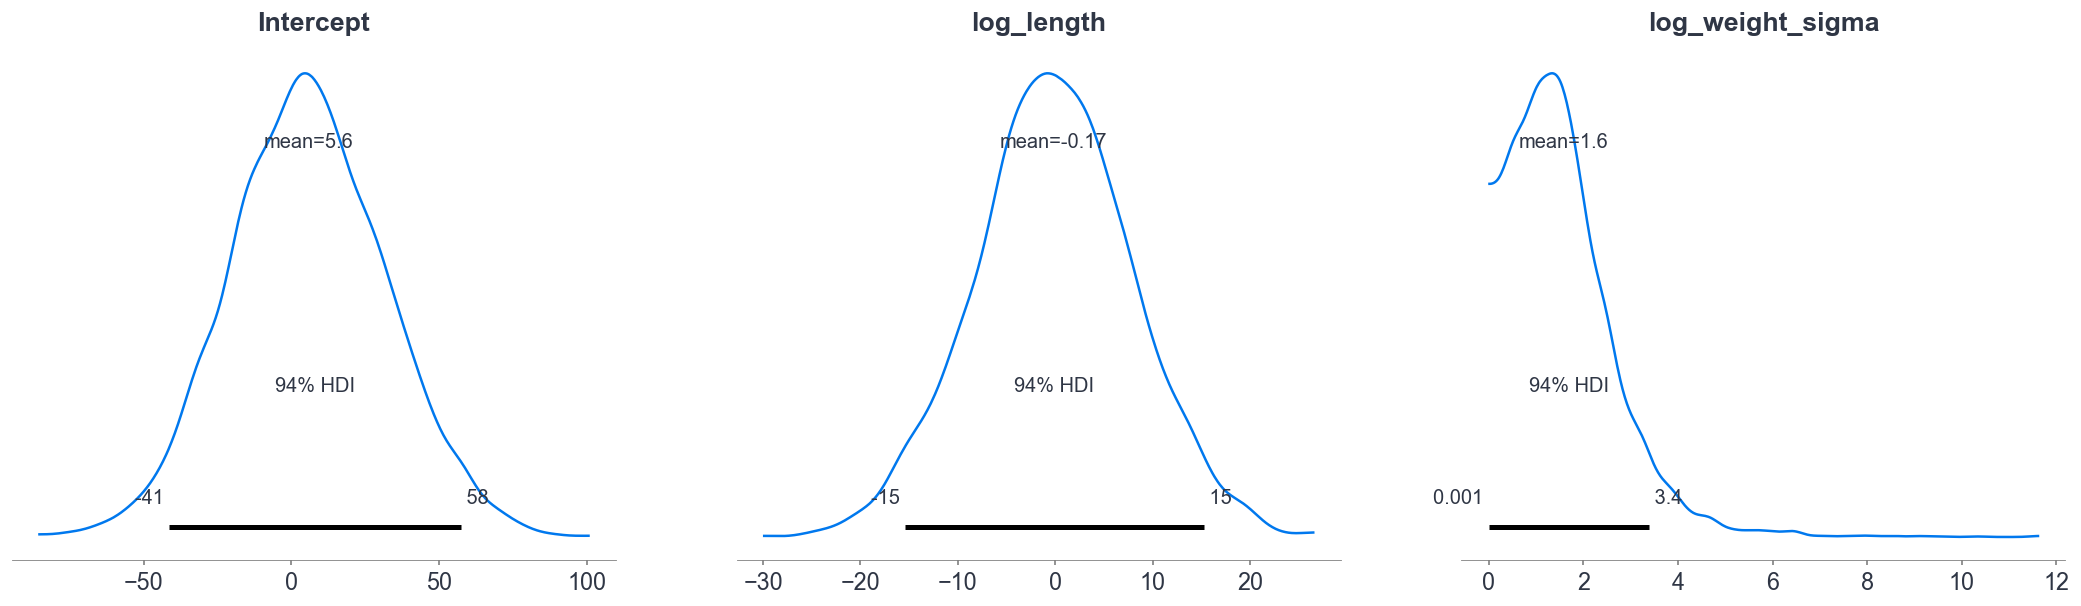

In [21]:
model.plot_priors();

As a tool, Bambi not only helps us to build models more easily, it also gives a lot of utilities we can use to explore the model and things related to it. For example, we can visualize the prior distributions very easily with the `.plot_priors()` method.

Here we see

* The prior for the `Intercept` is centered around 0 and its bulk ranges from -50 to 50
* The prior for the `log_length` slope is also centered around 0, and most of the probability is between -15 and 15
* And the prior for the scale of the error term `log_weight_sigma` is always positive, and most of the probability mass is between 0 and 4

**Animation idea:** Highlight the different panels as I interpret them

## Graphs? Here you have

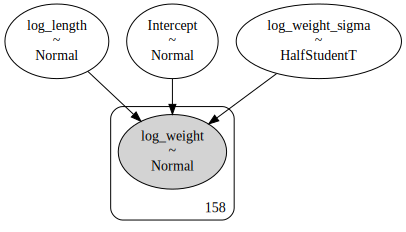

In [22]:
model.graph()

One of the other byproducts is the ability to create a model graph, using the plate representation that many love. It is so common to ask this with PyMC models, that Bambi offers it for free as well. All we need to do is call the `.graph()` method.

In this case, we see the three parameters are scalar values since there's no number attached to them. And the `log_weight` plate is the likelihood for which we have 158 observations. See it says `Normal`, so we are sure it's a Gaussian or Normal regression model.

Obviously this is not the only way one could access this information. Here, we're simply showing the versatility of the library and how you can perform different tasks. The preferred method is a matter of taste and familiarity, and it's up to you.

## Fit the model

In [23]:
idata = model.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, log_length, log_weight_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


In [24]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,-4.627,0.239,-5.053,-4.166
log_length,3.144,0.074,2.998,3.275
log_weight_sigma,0.374,0.022,0.333,0.414


There's nothing novel when it comes to fit the model. And that's a good thing actually! It's great not be forced to deal with the intricate things that are happening under the hood. The resulting `InferenceData` object, `idata`, can be used to obtain insights from the posterior. So we use the familiar `az.summary()`.

* The mean of the posterior of the slope for `log_length` is 3.144, and the HDI ranges from 2.998 to 3.275.
    * The posterior is very clear: the longer the fish, the larger the weight
    * Cautious note: the slope parameter is in the logarithmic scale!

For those who really want an interpretation, we could say something as follows:

"The log-weight increases by 3.14 log-grams on average, per additional log-centimeter in the fish length."

You see? Transformations are great, but they can really mess up interpretations!

## Plots for the win

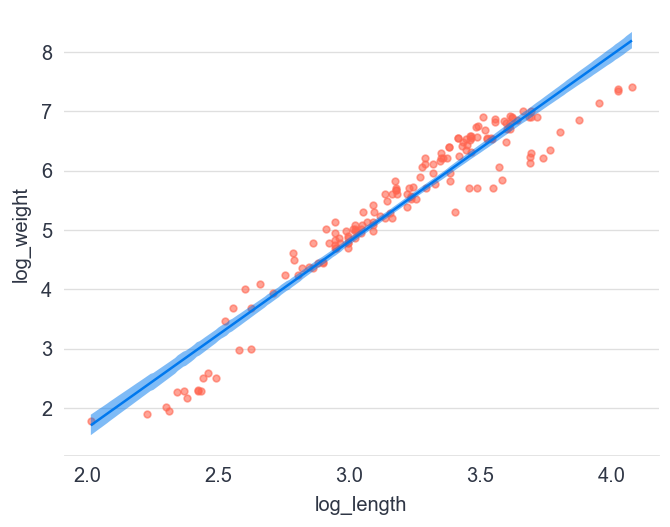

In [25]:
from bambi.plots import plot_cap

fig, ax = plt.subplots()
ax.scatter(data["log_length"], data["log_weight"], color="C4", alpha=0.6, s=16)
plot_cap(model, idata, "log_length", ax=ax);

Do you remember we said Bambi not only helps to create the models but also to do additional stuff with them? Now we have the perfect example. 

You may recall how much work it took us to create a visualization that overlaps the data and the fitted model. Well, you know what? Bambi gives that for free! 

There's a function, called `plot_cap()`, which stands for Conditional Adjusted Prediction, that plots the fitted curve plus the 94% HDI for us. What's even better, is that it works with any model we create with Bambi, not just linear regression. 

In this case, we see that combining a regular scatterplot of the data and `plot_cap()` we can obtain a visualization that shows how well the model approximates the relation between `log_length` and `log_weight`. Since we're in the transformed scale, the fitted curve is straight.

**A humble request from the deep of my heart:** Please, don't read this function as `plot_crap`! 🤣

## Back in the original scale

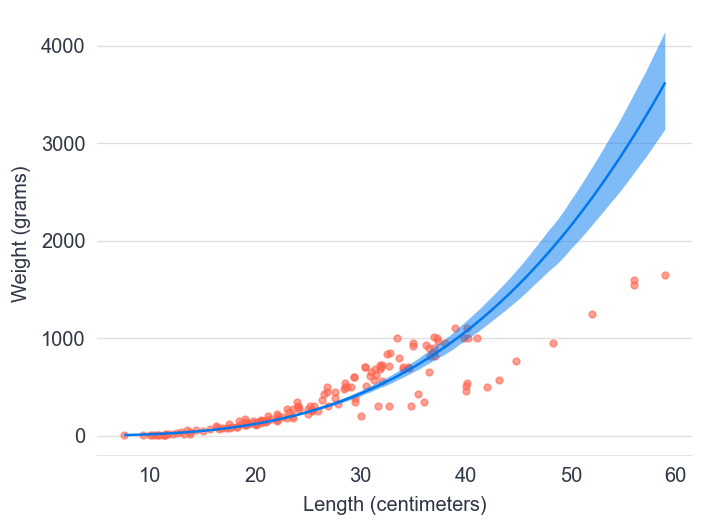

In [26]:
transforms = {"log_length": np.exp, "log_weight": np.exp}
fig, ax = plt.subplots()
ax.scatter(data["Length1"], data["Weight"], color="C4", alpha=0.6, s=16)
plot_cap(model, idata, "log_length", transforms=transforms, ax=ax)
ax.set(xlabel="Length (centimeters)", ylabel="Weight (grams)");

And there's even more to this `plot_cap()` wonder I love so much. We can pass a dictionary of transformations into the `transforms` argument. This tells the function to use functions to transform the variables before creating the chart. Do you start seeing how this can be useful? 

Since we used the logarithmic transformation, we can use its inverse, the exponential transformation, to bring variables back into their original scale. How cool is that?!

This is just the tip of the iceberg. This is just a Matplotlib visualization. Once we have it, we can put a little more work into it to make it even more amazing.

But this is enough for this section... We've done a lot already, and it's time for the section recap!

## Section Recap

* Adding a numerical predictor is so easy
    * Just add a term on the right-hand side of the model formula
* Bambi simplifies the workflow
    * Creating the model
    * Checking the priors
    * Fitting the single slope model
    * Plotting our fitted line with `plot_cap()`
* `plot_cap()` allows visualizing the curve fitted by the model
    * It's easy to use
    * It's versatile
    * It's cool! 😎

# Section 50: Transformations in Bambi

## Making it even simpler 

We simplified the model construction by using Bambi. But what if we could simplify our workflow even more?

## Let's be honest

We don't really need to do

```python
data["f_of_x"] = f(data["x"])
bmb.Model("y ~ f_of_x", data)
```

We can simply do 

```python
bmb.Model("y ~ f(x)", data)
```

We repeated so many times Bambi is here to make things simpler... And having to transform variables _before_ creating the model, is actually quite bothering. Isn't there a better solution?

I apologize deeply because I have not been very honest with you. I lied! And I feel very ashamed!

What if I tell you it's actually not needed to transform variables and store them in new columns before creating the model? Would that be cool? Would you forgive me? Then we're on a lucky day!

Turns out transformations are such an important topic, that Bambi allows using inline transformations. This is really a cool feature. Instead of having to pre-compute transformations, you can simply use the function within the formula. Bambi will know how to handle it 😉

## Inline transforms in action

In [27]:
model = bmb.Model("log(Weight) ~ 1 + log(Length1)", data)
model

Formula: log(Weight) ~ 1 + log(Length1)
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 5.41, sigma: 26.3354)
    log(Length1) ~ Normal(mu: 0, sigma: 8.1834)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1.322)

In [28]:
idata = model.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, log(Length1), log(Weight)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


See the inline transformations in action. Do you want transformed variables? You get transformed variables and it's still one-liner! How cool is that?

Instead of having to derive new columns, with the transformed variables and new names, we can simply pass the transformation on the fly. The `log()` function is a built-in transformation. We don't even need to have NumPy loaded in our session. Bambi can handle it on its own.

**Exercise idea** (or, should we do it in this section?)

* Use `plot_cap()` with this model. 
    * What do you see?
    * What's the scale of each variable?
    * Why?
    * How can you put everything on the transformed scale?
    * And everything on the untransformed scale again?

## A kind of magic

**User defined functions**

* Functions available in the environment where the model is created
    * Can be a custom function (`fun`) or available in a library (`np.cos` for example)

**Built-in functions**

* Basic built-in functions
    * `log()`
    * `exp()`
    * `abs()`
* Advanced built-in functions
    * `center()`
    * `scale()`

As Freddie Mercury said -- It's a kind of magic. Most people will be happy just knowing this works, no matter if it's magic or not. But we're in this course because we actually want to know how things works!

The story is that transformations are functions (Python functions). Bambi can use two types of transformations. The first type, Python functions that are available in the namespace where the model is created. Since we have imported NumPy as `np`, we coul have used `np.log()`, for example.

And there's more! Bambi also comes with several built-in transformations that make statistical modeling easier. In some cases they are convenient wrappers around simple functions such as `log()`, `exp()`, or `abs()`, and in other cases they are more complex transformations like `center()` or `scale()`.

## Adavanced built-in functions

* `center(x)`

$$
\text{center}(x) = x - \text{mean}(x)
$$

* `scale(x)`

$$
\text{scale}(x) = \frac{x - \text{mean}(x)}{\text{sd}(x)}
$$

Sometimes one wants to center a variable (subtract its mean) or scale the variable (subtract its mean and divide by its standard deviation). Instead of having to do it manually, or needing to write our own custom function, Bambi already provides all that for free.

And let me give you a piece of advice. It's much better to use these built-in transformations than to create your own versions. The details are complex, but basically, these transformations are using information from the training dataset to compute the mean and the standard deviation. If it's the case you have a test dataset, you want to make sure those observations use the same mean and standard deviation that were used when fitting the model. And believe me, it's not trivial to handle these issues manually. I can tell from my own experience 😅.

## Custom operations

* What if I want a term...
    * Divide by 100?
    * To the second power?

You may be tempted to do this...

```python
"y ~ x / 100"
"y ~ x ** 2"
```

But instead, do this

```python
"y ~ I(x / 100)"
"y ~ I(x ** 2)"
```

or this

```python
"y ~ {x / 100}"
"y ~ {x ** 2}"
```

There are also many other common operations that one may want to carry on, but they are simply not provided as built-in functions. Let's say we have a variable in centimeters but we actually want to use it measured in meters, so we divide it by 100. Or perhaps, there's something we want to compute powers on. How can we do that? 

One of the first things we may be tempted to do is using the division operator and power operators `/` and `**`. However, the operators `/` and `**`, as many other operators, have a different meaning in the formula (mini) language.  When we want these operators to have the same meaning they would do in Python (or actually, in regular math!) we have to _escape_ them. To do that we can use the `I()` function or curly brackets. Anything written within them will be evaluated as regular Python code. 

## (Go go) power formulas

**Note** I'm paraphrasing a song that said "go go power rangers". Do you think it's a popular reference?

What can we find or specify in a model formula?

* The response variable

* The predictors

* Transformations
    * Of several kinds!

I always feel I can't emphasize this enough. Model formulas are extremely powerful. In a very short piece of code one can encode lots of information: the response, the predictors, and transformations of several types! This simplifies communication, reduces misunderstanding, and makes modeling easier!

Downsides? Yes, of course there are downsides! It requires us to learn a new thing and sometimes subtle differences can lead to substantially different models. All that is true. But at the same time, trust me. It's a very high ROI skill. When you get to master it, many things become so much clearer and easier. 

## Section Recap

* Bambi can simplify not only the model but also the data processing steps
* Transformations are one of the most powerful concepts in ML as a whole
s* Bambi takes tranformations from different sources
    * Built-in: There are various transform functions 
    * User defined: Create your own function and use it in the model formula
* Mastering model formulas... 
    * Is a highly valuable skill
    * Can simplify a lot your work

# Section 60: Modeling categories

**ADD PICTURE**

There's always a tough section in this course. And probably this is the toughest section in this lesson.

## Categorical is not the same as numeric

* Length, Width, and Height are numeric
    * Math makes total sense

* Species is categorical
    * Math does not make sense

* We need to treat categorical variables in a different way
    * We did it with PyMC in the previous lesson
    * Split the line into multiple lines

All the body measures of the fish are numeric, and thus regular math makes total sense. We can add the length of two fish, for example, and the result is a meaningful thing. 

But species is of a different kind. We cannot do the same kind of math with the species of the fish. That's why species has to be treated in a different way when creating our model. And that's what we did in the previous lesson with PyMC -- we added a different intercept and slope for each species. At that time we showed it was the same than splitting the regression line into multiple lines.

## Categorical **is** the same as numeric

* Bambi makes life easier 

* Using categories is the same

* Bambi knows how to handle all the details for us

Bambi is here to make our lives easier. A big part of that is removing all the burden associated with dealing with categorical variables. 

In the previous lesson we saw it required a non-trivial amount of work, and it was just one categorical variable! 

With Bambi, using categorical variables is the same thing as using numeric variables. We simply pass the name of the variable into the model formula. 

## Modeling categories

In [29]:
model_c1 = bmb.Model("log(Weight) ~ 1 + Species", data)
model_c1

Formula: log(Weight) ~ 1 + Species
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 5.41, sigma: 4.6946)
    Species ~ Normal(mu: [0. 0. 0. 0. 0. 0.], sigma: [12.9856  6.9091 10.6655 10.1609 11.6298 17.2909])

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1.322)

* There is no need to perform _any_ data manipulation step

Let's create the model. The response is the logarithm of the `Weight` of the fish, and we have an intercept and the species as predictors. When we print the model, notice the parameters of the prior for the `Species` predictor are arrays. This is because there are multiple species.

Can you spot where we perform data manipulation steps for the species? I bet you can't! 

To create the model in Bambi we don't need to tell it `Species` is of a different kind. Bambi is very smart and is capable of detecting categorical variables and it handles them in an appropriate way.

It's not completely free of any cost, though. It comes together with a couple of tricky details we'll cover in just a moment.

## Fit

In [30]:
idata_c1 = model_c1.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, Species, log(Weight)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [31]:
np.exp(az.summary(idata_c1)["mean"])

Intercept             581.144828
Species[Parkki]         0.233868
Species[Perch]          0.404542
Species[Pike]           1.001001
Species[Roach]          0.243169
Species[Smelt]          0.018188
Species[Whitefish]      0.796124
log(Weight)_sigma       2.159766
Name: mean, dtype: float64

* Fit the model
    * Very fast, out of the box
* Explore the model coefficients
    * Use the exponential function, so we transform results back to the original scale (we are modeling the log(Weight))
* This opens some questions...

## What's going on?

In [32]:
np.exp(az.summary(idata_c1)["mean"])

Intercept             581.144828
Species[Parkki]         0.233868
Species[Perch]          0.404542
Species[Pike]           1.001001
Species[Roach]          0.243169
Species[Smelt]          0.018188
Species[Whitefish]      0.796124
log(Weight)_sigma       2.159766
Name: mean, dtype: float64

* The dataset has 7 species, but this table shows 6. Why?
* The value of `Intercept` differts a lot from the `Species`. Why?

**Animation note:** 

* Add a number next to the Species parameters so it's easy to see there are 6 of them (like the index of a table)

## Zoom into the formula

<center>
  <img src="imgs/formula_1_plus_species.png" style="width:60%"; />
</center>

To understand what's going on, and why the posterior doesn't show one of the species, we need to understand how the model formula is being mapped onto a statistical model. This is an extremely important part of the course, because it explains complexities of model formulas in deep detail.

The expectation of the response variable, in this case, the log weight, is equal to the sum of two components:

1. An `Intercept` parameter, $\beta_0$, which is the same for all the fish of all species
1. A `Species` parameter, $\beta_{1, j}$
    * This is **not a slope**. It's not multiplying a numeric predictor
    * Think of it as deviations from the intercept specific to each species

## Zoom into the formula: Going deeper

<center>
  <img src="imgs/formula_1_plus_species_extended.png" style="width:60%"; />
</center>

Moving a step forward, we can list all the `Species` parameters. We have 7 species, so these are: $\beta_{1, 1}, \beta_{1, 2}, \cdots, \beta_{1, 7}$. Depending on the value of $j$, which represents the species, we select a different $\beta_1$ parameter. Let's see how it works below.

## The mapping

<center>
  <img src="imgs/expected_values_1_plus_species.png" style="width:45%"; />
</center>

We can write down the expected log weight for every species. We just need to combine $\beta_0$ and the right $\beta_1$ parameter. This way, we can see...

* The mean for the Bream species is $\beta_0 + \beta_{1, 1}$
* The mean for the Parkki species is $\beta_0 + \beta_{1, 2}$
* And so on ... until we reach Whitefish, whose mean is $\beta_0 + \beta_{1, 7}$ 

Let's do another exercise now: count the number of quantities of interest, the mean log weight for each species, and the number of parameters we use to do so. It will help us to detect a problem that is in front of us.

* Starting with Bream, we're interested in estimating one thing, the mean response for the Bream species, and we have two parameters: $\beta_0$ and $beta_{1, 1}$.
* Continuing with Parkki, we have two quantities of interest, and three parameters. $\beta_0$ and $beta_{1, 1}$, and $\beta_{1, 2}$.
* And so on... 
* Until we reach Whitefish. At this point we want to estimate 7 means, and we have 8 parameters.

And that's exactly **the problem**: We have 7 equations and 8 parameters!

* It is a problem with infinite solutions!
    * In other words: the model is non-identifiable.
* How to make the solution unique? **Choose a restriction**
    * And this creates a new problem!
    * Which restriction do we choose?

**Question:** Split narrative in two slides?

**Animation note:** 

* Reveal line by line, up to the second line, then just reval all of them
* In the second round, where we count parameters, have a count of the number of things we want to estimate (the means) and the number of parameters

## Reference encoding (what Bambi does by default)

<center>
  <img src="imgs/formula_1_plus_species_extended_with_zero.png" style="width:60%"; />
</center>

* One solution: Setting one of the coefficients to zero. 
    * This level is known as "reference level" or "pivot category"
* This is like "dropping a level". But actually, it's a little misleading since the level exists, but it's zero.
    * That's why it does not appear in the posterior
* By default, Bambi drops the first level of the categorical variable
    * In this case, it's Bream.
* Now the model is identifiable

## An identified model

<center>
  <img src="imgs/expected_values_1_plus_species_with_zero.png" style="width:45%"; />
</center>

If we go back to the diagram that helped us spot we had 8 parameters and 7 equations and replace the 0 in the right place, we can now see we have 7 parameters and 7 equations. Fixing one parameter to 0 removes one parameter from the system of equations and allows it to have a unique solution, which is what we want.

* Number of things to estimate: 7
* Number of parameters: 7
* The problem has a unique solution! That's great!
* We didn't have to do anything of this by hand. This is the explanation of what's happening and why that's happening.
* Bambi always takes cares of all these details
* With PyMC, we are the ones in charge of taking care of all these details
    * **Ideas**
    * Create a model where we have the intercept and the coefficient for every species without dropping the level and analyze the result
        * It could be an exercise. It will be fun, but it can be frustrating too (how do they know what problems to look for?)

**Note**

* I think some of the notes above can go into the section recap.

## So what...

is the meaning of the `Species` parameters?

<center>
  <img src="imgs/expected_1_plus_species_expanded.png" style="width:50%"; />
</center>

It's clear $\beta_0$ is the mean response for the Bream species, the reference level, because it's the only parameter that appears in that line. But $\beta_0$ is also used in the computation of the mean of all the other species. So what?

All this means the $\beta_{1, j}$ are not the mean values for the different species. They are differences or deflections from the mean of the reference level. Combining both parameters, the mean of the reference level and the deflection for a given species, we obtain the mean of that species.

Is this always the case with coefficients? Nope. It depends on the restriction that is applied to the coefficients. Different will lead to different interpretations. Bambi applies the restriction where you set the coefficient for one  the levels to zero. This is also known as reference encoding.

## It's so complicated... isn't there another solution?

* Bambi made it so easy to create the model, but analyzing the results is so complicated!
* Fortunately, this case allows to use another solution
* Do we really need an intercept term? What's the purpose?
    * Answer: We don't really need the intercept term!
* **Solution:** Remove the intercept parameter!

**Leading question:** If the number of parameters is the same than the number of things we want to estimate. Can't we map parameters and quantities more straightforwardly so parameters have a more interpretable meaning?

Also, we didn't have to think about encodings in PyMC... why? (answer: the PyMC model we built is like the one we show next)

## Remove the intercept

In [33]:
model_c2 = bmb.Model("log(Weight) ~ 0 + Species", data)
model_c2

Formula: log(Weight) ~ 0 + Species
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Species ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0.], sigma: [ 7.9585 12.9856  6.9091 10.6655 10.1609 11.6298 17.2909])

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1.322)

* For historical reasons, it's not enough to remove the `1` in the formula to remove the intercept
* We need to use a `0` instead of the `1`. 
    * It tells Bambi not to use an intercept term
* All the rest is the same than before

## Fit again

In [34]:
idata_c2 = model_c2.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Species, log(Weight)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [35]:
np.exp(az.summary(idata_c2)["mean"])

Species[Bream]        578.246356
Species[Parkki]       137.002613
Species[Perch]        234.393189
Species[Pike]         582.308281
Species[Roach]        140.611392
Species[Smelt]         10.580366
Species[Whitefish]    460.355952
log(Weight)_sigma       2.159766
Name: mean, dtype: float64

* Fitting the model is not the important thing here.
* What matters are the parameters in the model
    * No intercept parameter anymore
    * All species are included now!
* The scale of the `Species` parameter changed a lot from the previous model.
    * Why? Let's figure it out!

## Another solution

<center>
  <img src="imgs/formula_0_plus_species.png" style="width:60%"; />
</center>

* We changed the model formula to remove the intercept
    * We did so including the zero in the formula.
* We kept the `Species`
    * Let's expand it again

## Another solution

<center>
  <img src="imgs/formula_0_plus_species_extended.png" style="width:60%"; />
</center>

* As in the previous case, the mean for a species is the sum of the two components
* But the first component now is 0. So it's actually not there, we don't need to add it.

## Mapping a simpler model

<center>
  <img src="imgs/expected_values_0_plus_species.png" style="width:45%"; />
</center>

* The mapping is so much simpler now!
* 7 quantities to estimate and 7 parameters.

What's even better

* There's a unique solution without having to impose a restriction!
* Parameters have a one-to-one mapping with quantities of interest
    * **Each parameter is the mean of the group!**
    * This is way better!

## Is it a different model?

* Nope
* It's a different parametrization
* Models are equivalent
    * Extract the same conclusions
    * Compute the same predictions

## Don't believe it? Just see

Both models are equivalent!

In [36]:
b_0 = idata_c1.posterior["Intercept"]
b_1j = idata_c1.posterior["Species"].pad({"Species_dim": (1, 0)}, constant_values=0)
b_1j = b_1j.assign_coords({"Species_dim": np.unique(data["Species"])})
species_mean = b_0 + b_1j
species_mean.head({"chain": 1, "draw": 1})

<xarray.DataArray (chain: 1, draw: 1, Species_dim: 7)>
array([[[6.36441051, 4.79323692, 5.43531705, 6.30620524, 5.07982777,
         2.37748141, 6.2300639 ]]])
Coordinates:
  * chain        (chain) int64 0
  * draw         (draw) int64 0
  * Species_dim  (Species_dim) object 'Bream' 'Parkki' ... 'Smelt' 'Whitefish'

* First we need to compute the sum between the $\beta_0$ and the $\beta_{1, j}$
    * We left pad the species posterior to add the 0 for the first species
    * Then we assign the coordinate values again, since it doesn't have the reference level (Bream)
    * Then simply sum both DaraArrays
* See the result. Now we have the 7 species.

## Don't believe it? Just see

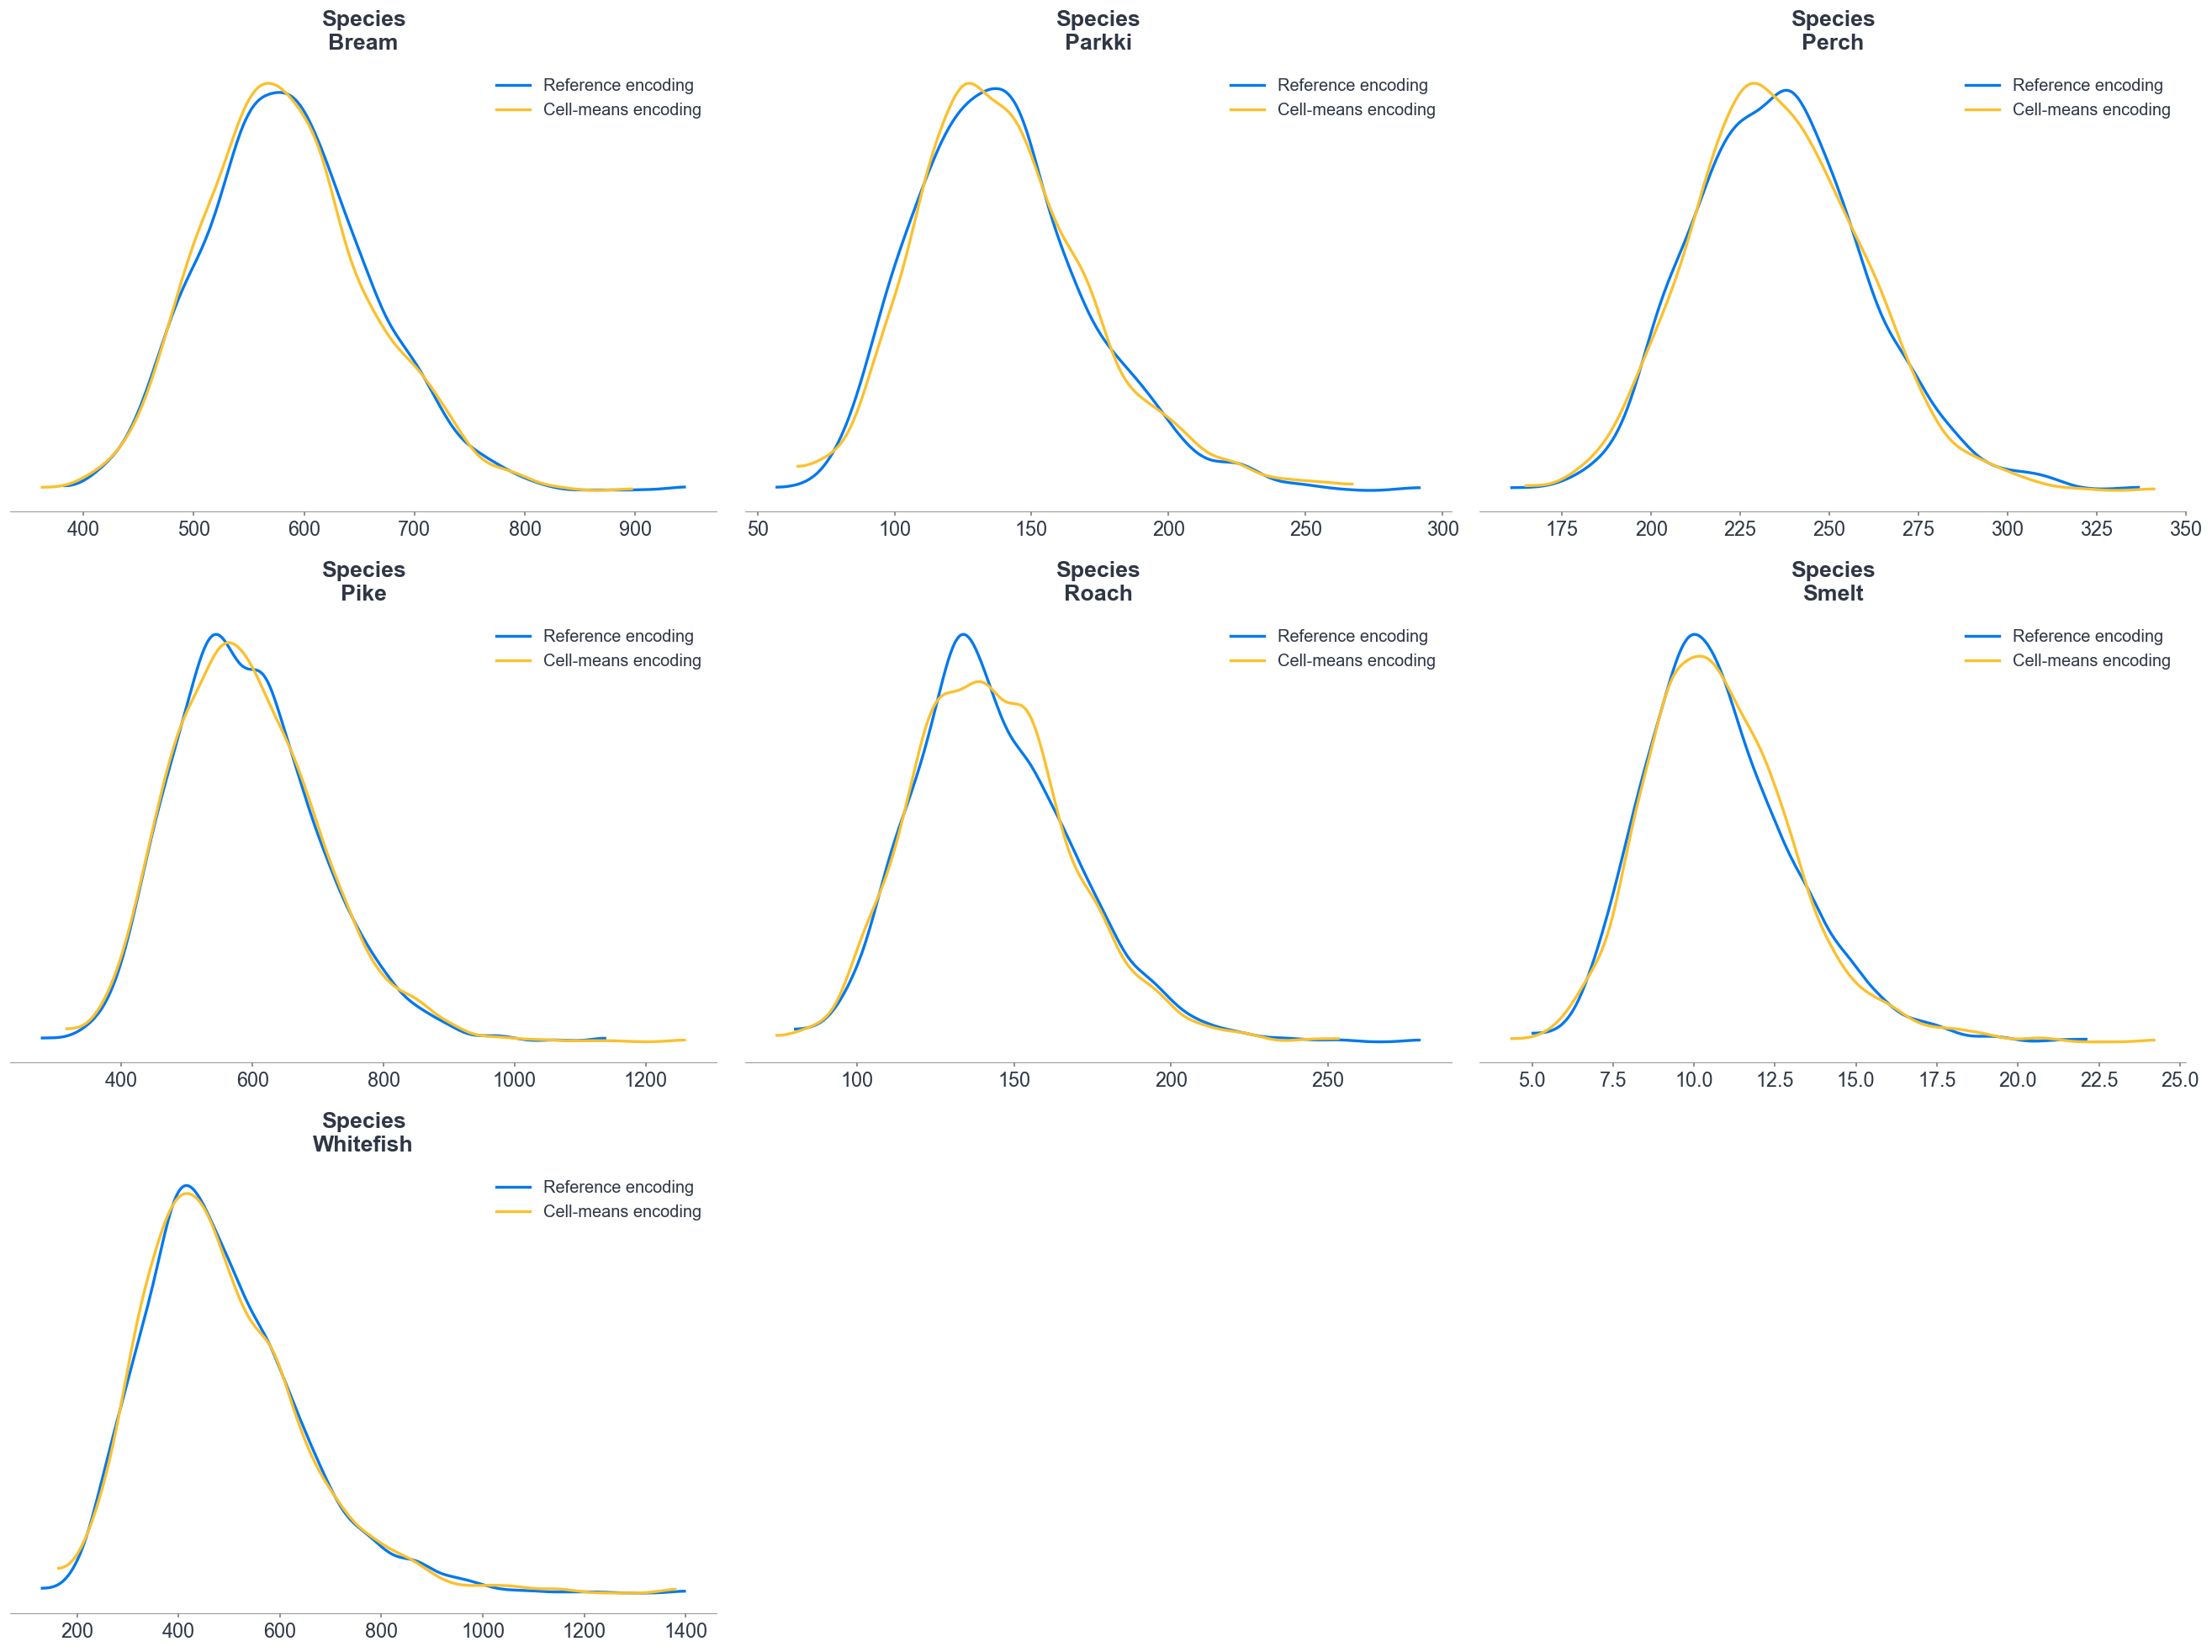

In [37]:
axes = az.plot_posterior(
    species_mean,
    hdi_prob="hide",
    point_estimate=None,
    transform=np.exp,
    lw=2,
    label="Reference encoding"
)

az.plot_posterior(
    idata_c2.posterior["Species"],
    hdi_prob="hide", 
    point_estimate=None,
    transform=np.exp, 
    ax=axes, 
    color="C1",
    lw=2,
    label="Cell-means encoding"
)

plt.tight_layout()

* We can plot the posteriors from both models
* In both cases, we obtain the same prediction for all the species
* This is because they're the same models!
* Note: The exp transform is because we're modeling the response in the log scale

## Section Recap

* Bambi handles categorical variables out of the box
    * There's no need to perform any manual work
    * Interpreting results require us to be familiar with model parametrization
* Categorical variables require more care
    * Restrictions are applied to make the model identifiable
    * Bambi handle them automatically for us
* Equivalent models can be expressed in different ways
    * `log(Weight) ~ 1 + Species` and `log(Weight) ~ 0 + Species` are equivalent
    * The interpretation of parameters differ
    * Pick the one that suits your needs
* ...?

# Section 70: Understanding encodings

**NOTE:** I got excited writing and I covered most (if not all) concepts in Section 60. But it looks like a very long section. So maybe it's sensible to split Section 60 in two, and make the second part the new Section 70, showing the model with cell means encoding (y ~ 0 + Species)

## Section Recap

# Section 80: The full model

## The model

$$
\begin{aligned}
\beta_{0,j} & \sim \text{Normal}(0, \sigma_{\beta_0}) \\
\beta_{1,j} & \sim \text{Normal}(0, \sigma_{\beta_1}) \\
\sigma & \sim \text{HalfNormal}(\sigma_\varepsilon) \\
\mu_{i, j} & = \beta_{0,j} + \beta_{1,j} \log{(\text{Length}_{i, j})} \\
\log{(\text{Weight}_{i,j})} & \sim \text{Normal}(\mu_{i, j}, \sigma)
\end{aligned}
$$

for $j=1, \cdots, 7$.

* For each species, we want a slope for `log(Length)`

## The model in Bambi

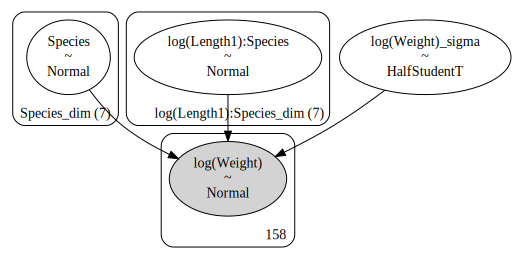

In [38]:
model_full = bmb.Model("log(Weight) ~ 0 + Species + log(Length1):Species", data)
model_full.build()
model_full.graph()

In [39]:
idata_full = model_full.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Species, log(Length1):Species, log(Weight)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.


## The interaction operator `:`

* We used a new thing, the interaction operator `:`
* `numeric:categoric` means we want a `numeric` slope for every category in `categoric`
* In our problem, `log(Length1):Species` means there's a `log(Length1)` slope for every species in `Species`

## Mapping the formula to coefficients

<center>
  <img src="imgs/formula_0_plus_length_plus_length_species.png" style="width:80%"; />
</center>

## The posterior

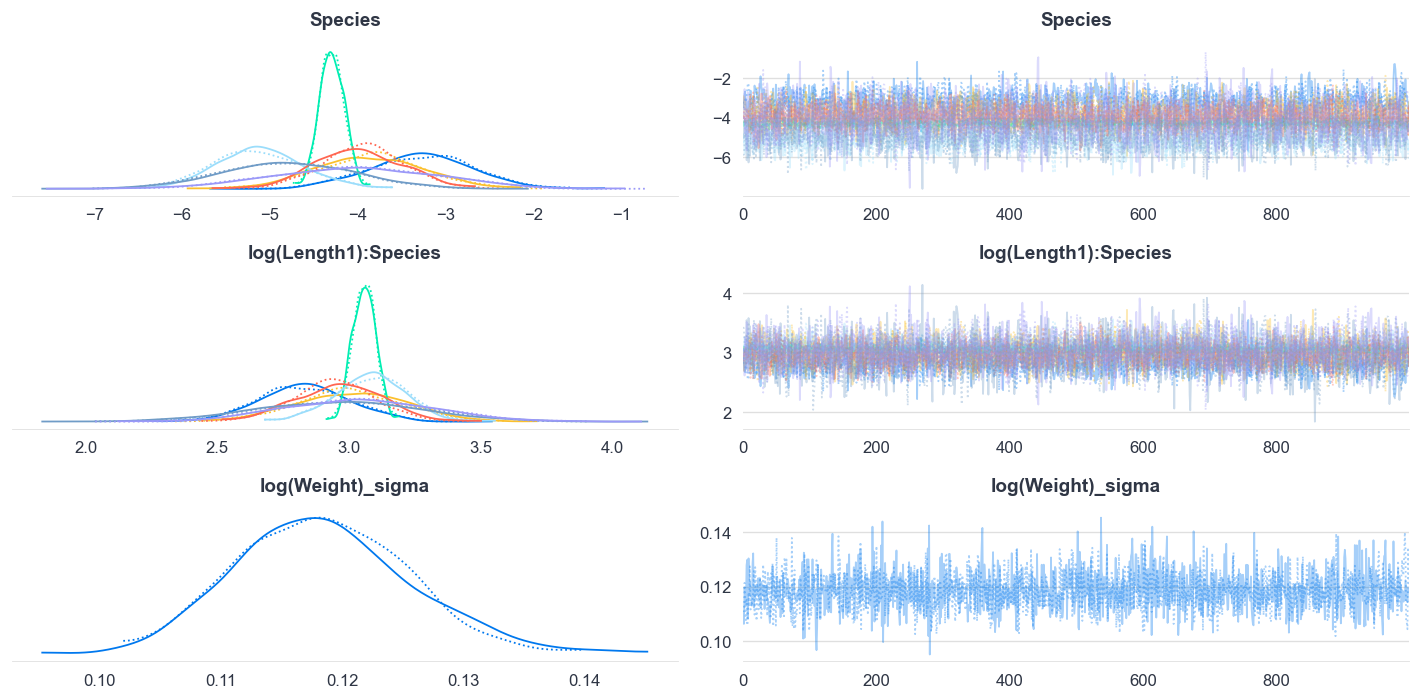

In [40]:
az.plot_trace(idata_full)
plt.tight_layout()

## An old friend

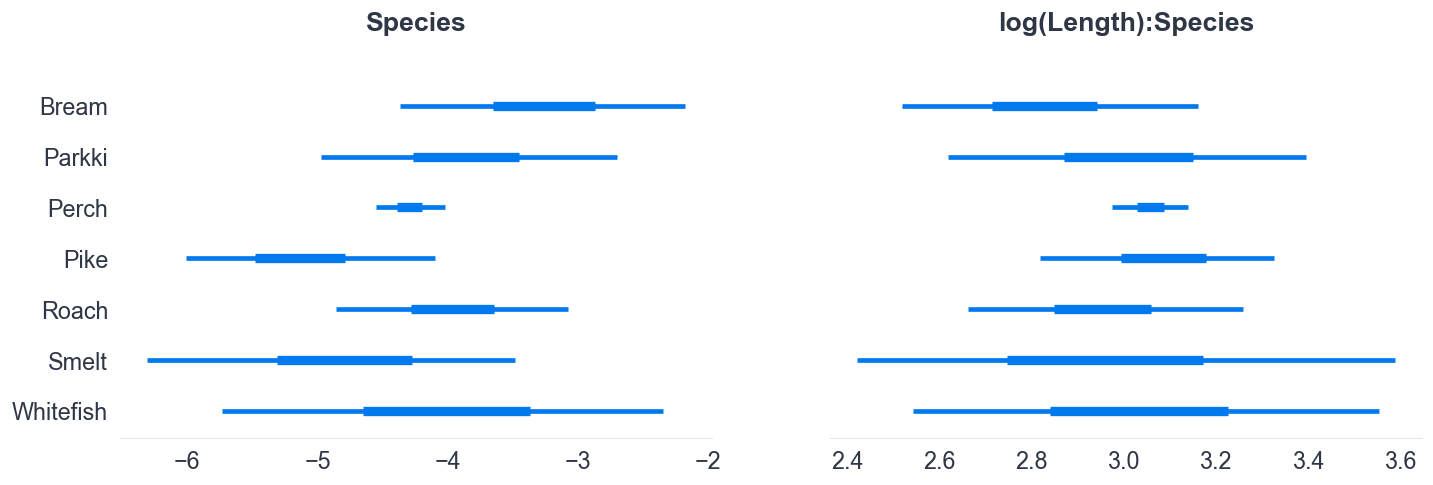

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4.2), sharey=True)
az.plot_forest(idata_full, var_names="Species", combined=True, linewidth=2.8, ax=axes[0])
az.plot_forest(idata_full, var_names="log(Length1):Species", combined=True, linewidth=2.8, ax=axes[1])
axes[0].set(title="Species", yticklabels=reversed(np.unique(data["Species"])))
axes[1].set(title="log(Length):Species");

* Does this remind you any othe plot we have created in the past?

## Conditional Adjusted Predictions

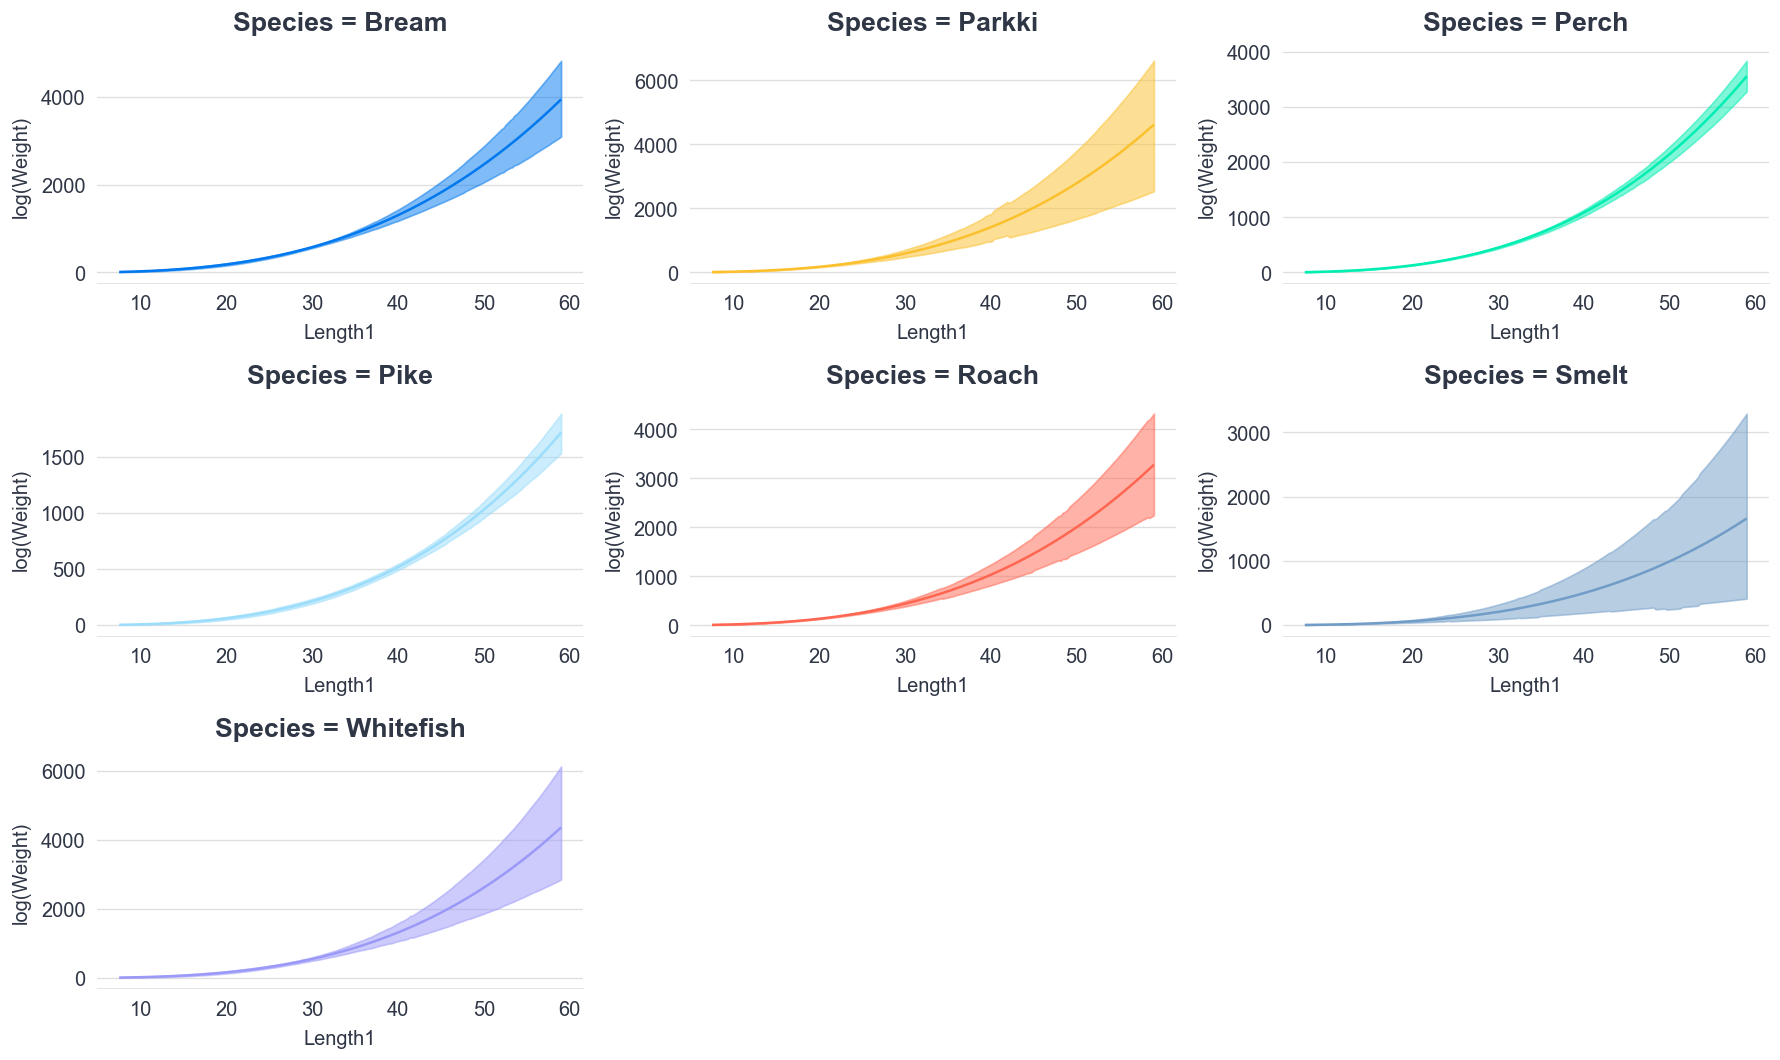

In [42]:
fig, axes = plot_cap(
    model_full, 
    idata_full,
    {"horizontal": "Length1", "color": "Species", "panel": "Species"},
    transforms={"log(Weight)": np.exp},
    legend=False,
    fig_kwargs={"figsize": (15, 9), "tight_layout": True}
);

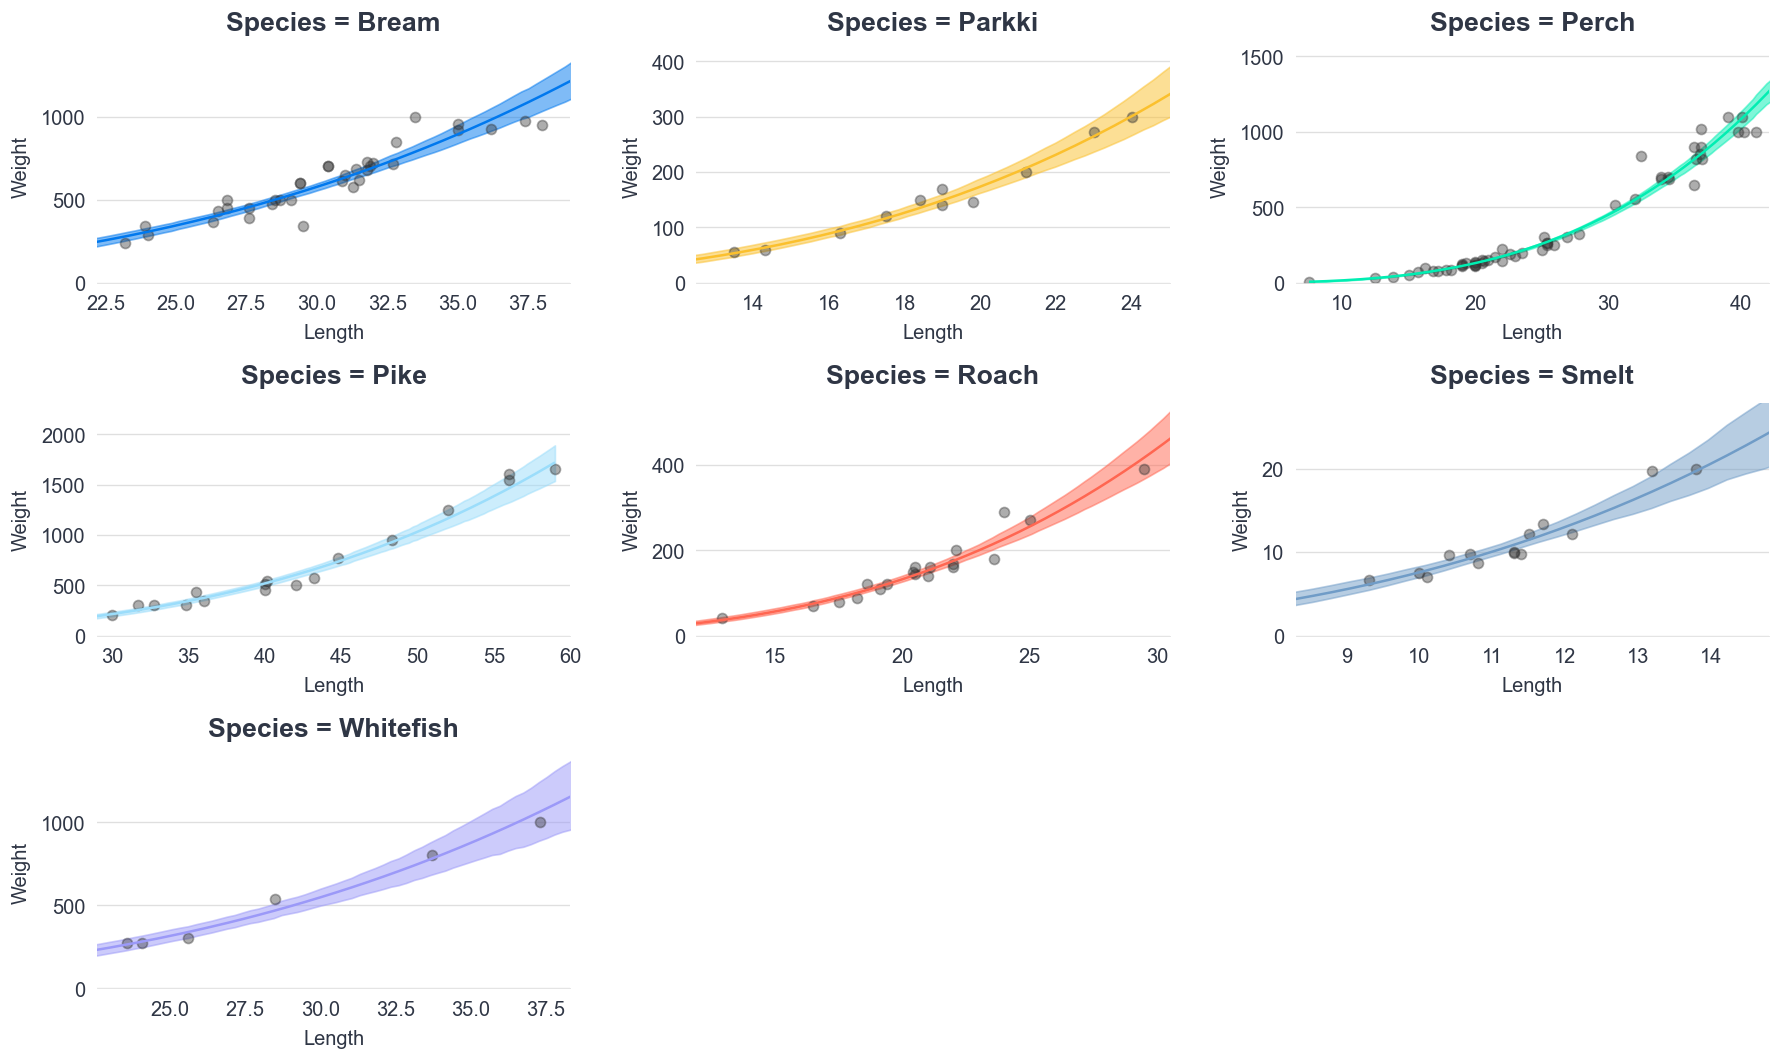

In [43]:
fig, axes = plot_cap(
    model_full, 
    idata_full,
    {"horizontal": "Length1", "color": "Species", "panel": "Species"},
    transforms={"log(Weight)": np.exp},
    legend=False,
    fig_kwargs={"figsize": (15, 9), "tight_layout": True}
);

for ax, species in zip(axes.ravel(), np.unique(data["Species"])):
    idxs = data["Species"] == species
    length_species = data.loc[idxs, "Length1"]
    weight_species = data.loc[idxs, "Weight"]
    ax.scatter(length_species, weight_species, color="0.2", alpha=0.4)
    ax.set(
        xlabel="Length", 
        ylabel="Weight", 
        xlim=(length_species.min() - 1, length_species.max() + 1),
        ylim=(0, weight_species.max() * 1.4)
    )

## Section Recap

## Section 90: Predictions

## In-sample vs Out-of-sample data

* It looks like a problem of different nature

* But not for Bambi

* Both of them are solved with the same method: `Model.predict()`

## Train-test split

In [44]:
df_test = data.sample(frac=0.1, random_state=1234).sort_index()
df_train = data.loc[data.index.difference(df_test.index)]
df_test.shape, df_train.shape

((16, 9), (142, 9))

* Let's generate our fake out-of-sample data. This is exactly the same train-test split we did in the first lesson.

## Create the model

In [45]:
model = bmb.Model("log(Weight) ~ 0 + Species + log(Length1):Species", df_train)
model

Formula: log(Weight) ~ 0 + Species + log(Length1):Species
Family name: Gaussian
Link: identity
Observations: 142
Priors:
  Common-level effects
    Species ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0.], sigma: [ 7.9067 13.5588  6.9837 10.1763  9.9293 11.4552 17.9235])
    log(Length1):Species ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0.], sigma: [2.3222 4.6028 2.1659 2.725  3.2592 4.7218 5.4423])

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1.3214)

* Unlike PyMC, you don't need to do anything special when you want to predict for out-of-sample observations
    * PyMC required us to pass data using `MutableData` containers. That's not required here
    * It's like any other Bambi model, nothing we need to handle in particular
* Notice the number of observations changed
    * We're using `df_test`, and not `data` anymore.

## Fit model

In [46]:
idata = model.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Species, log(Length1):Species, log(Weight)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 56 seconds.


## What do we want to predict?

Predict the mean weight

$$
E(\text{Weight}_i) = \mu_i
$$

Predict the individual weight

$$
\text{Weight}_i = y_i
$$

Obtaining predictions in Bambi is extremely easy. But the theory is not trivial. That's why we review it now.

There are two things we can predict

* The mean weight for an individual, which is also known as the expected value or expected weight
    * We refer to this as the **posterior distribution of the mean weight**
* The weight at the individual level
    * We refer to this as the **posterior predictive distribution**

Naturally, we expect the prediction at the individual level to be more uncertain than the prediction at the mean level since the latter is about an aggregate. But in many cases it's very important to obtain predictions at the invidual level. Like in our problem! The mean weight for a given fish doesn't satisfy us. We need uncertainty at the level of the individual fish. This is a tremendously important difference! 

You may also see the above quantities written with a hat on top. This is very common in statistical literature and the hat means the symbol represents an estimation.

* $\hat{\mu}_i$
* $\hat{y}_i$

**Note:** I think this can be confusing since I think the posterior predictive distribution is represented with $\tilde{y}_i$? I need to double check

## Predictions: Mean-level

Get predictions for the mean weight $\mu$

In [47]:
model.predict(idata, data=df_test)

In [48]:
idata.posterior["log(Weight)_mean"]

<xarray.DataArray 'log(Weight)_mean' (chain: 2, draw: 1000, log(Weight)_obs: 16)>
array([[[6.04133338, 6.54595466, 6.60725377, ..., 6.5172521 ,
         6.78205259, 2.05861554],
        [6.00097128, 6.61204566, 6.6862762 , ..., 6.4762195 ,
         6.73401878, 2.08146678],
        [5.97784522, 6.57017559, 6.6421292 , ..., 6.46844082,
         6.72297766, 2.09313236],
        ...,
        [6.03764999, 6.58467831, 6.65112883, ..., 6.47008725,
         6.73422768, 2.08898392],
        [6.05216235, 6.56283296, 6.62486691, ..., 6.45241795,
         6.71280331, 2.09311941],
        [6.03300367, 6.57276117, 6.63832847, ..., 6.52391982,
         6.78821975, 2.12602831]],

       [[6.02839329, 6.58378925, 6.65125624, ..., 6.48238986,
         6.73627305, 2.01789375],
        [5.98509808, 6.54164684, 6.60925386, ..., 6.47677963,
         6.73151903, 2.14698984],
        [5.96426992, 6.57257938, 6.64647405, ..., 6.47630763,
         6.7372801 , 2.00404469],
        ...,
        [5.99695452, 6.58638557, 6.65798698, ..., 6.51386932,
         6.77424777, 2.08911698],
        [6.00251323, 6.54394545, 6.60971618, ..., 6.50866854,
         6.77374957, 1.98788546],
        [6.0107124 , 6.57380246, 6.64220409, ..., 6.48627168,
         6.74549018, 2.01411215]]])
Coordinates:
  * chain            (chain) int64 0 1
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * log(Weight)_obs  (log(Weight)_obs) int64 0 1 2 3 4 5 6 ... 10 11 12 13 14 15

* There's no need to do any kind indexing and  `pm.set_data` wizardy
* Just pass a data frame with the out-of-sample observations, Bambi will handle all the rest
* By default, it obtains the posterior for the mean response
    * Which is what we represent with $\mu$
    * That's why it adds a variable called like the response, but with `_mean` appended

## Predictions: Individual-level

Get predictions for a single observation $y$

In [49]:
model.predict(idata, data=df_test, kind="pps")

In [50]:
idata.posterior_predictive

<xarray.Dataset>
Dimensions:          (chain: 2, draw: 1000, log(Weight)_obs: 16)
Coordinates:
  * chain            (chain) int64 0 1
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * log(Weight)_obs  (log(Weight)_obs) int64 0 1 2 3 4 5 6 ... 10 11 12 13 14 15
Data variables:
    log(Weight)      (chain, draw, log(Weight)_obs) float64 6.041 ... 2.021
Attributes:
    modeling_interface:          bambi
    modeling_interface_version:  0.9.1

* It's still the `.predict()` method
* We need to set the `kind` argument equal to `"pps"`
    * `"pps"` stands for posterior predictive sampling
    * This argument is by default equal to `"mean"`
* This adds a new group to the `InferenceData` object called `posterior_predictive`
    * It contains a variable with the same name than the response
    * It's `log(Weight)` in this case

## Visualize individual predictions

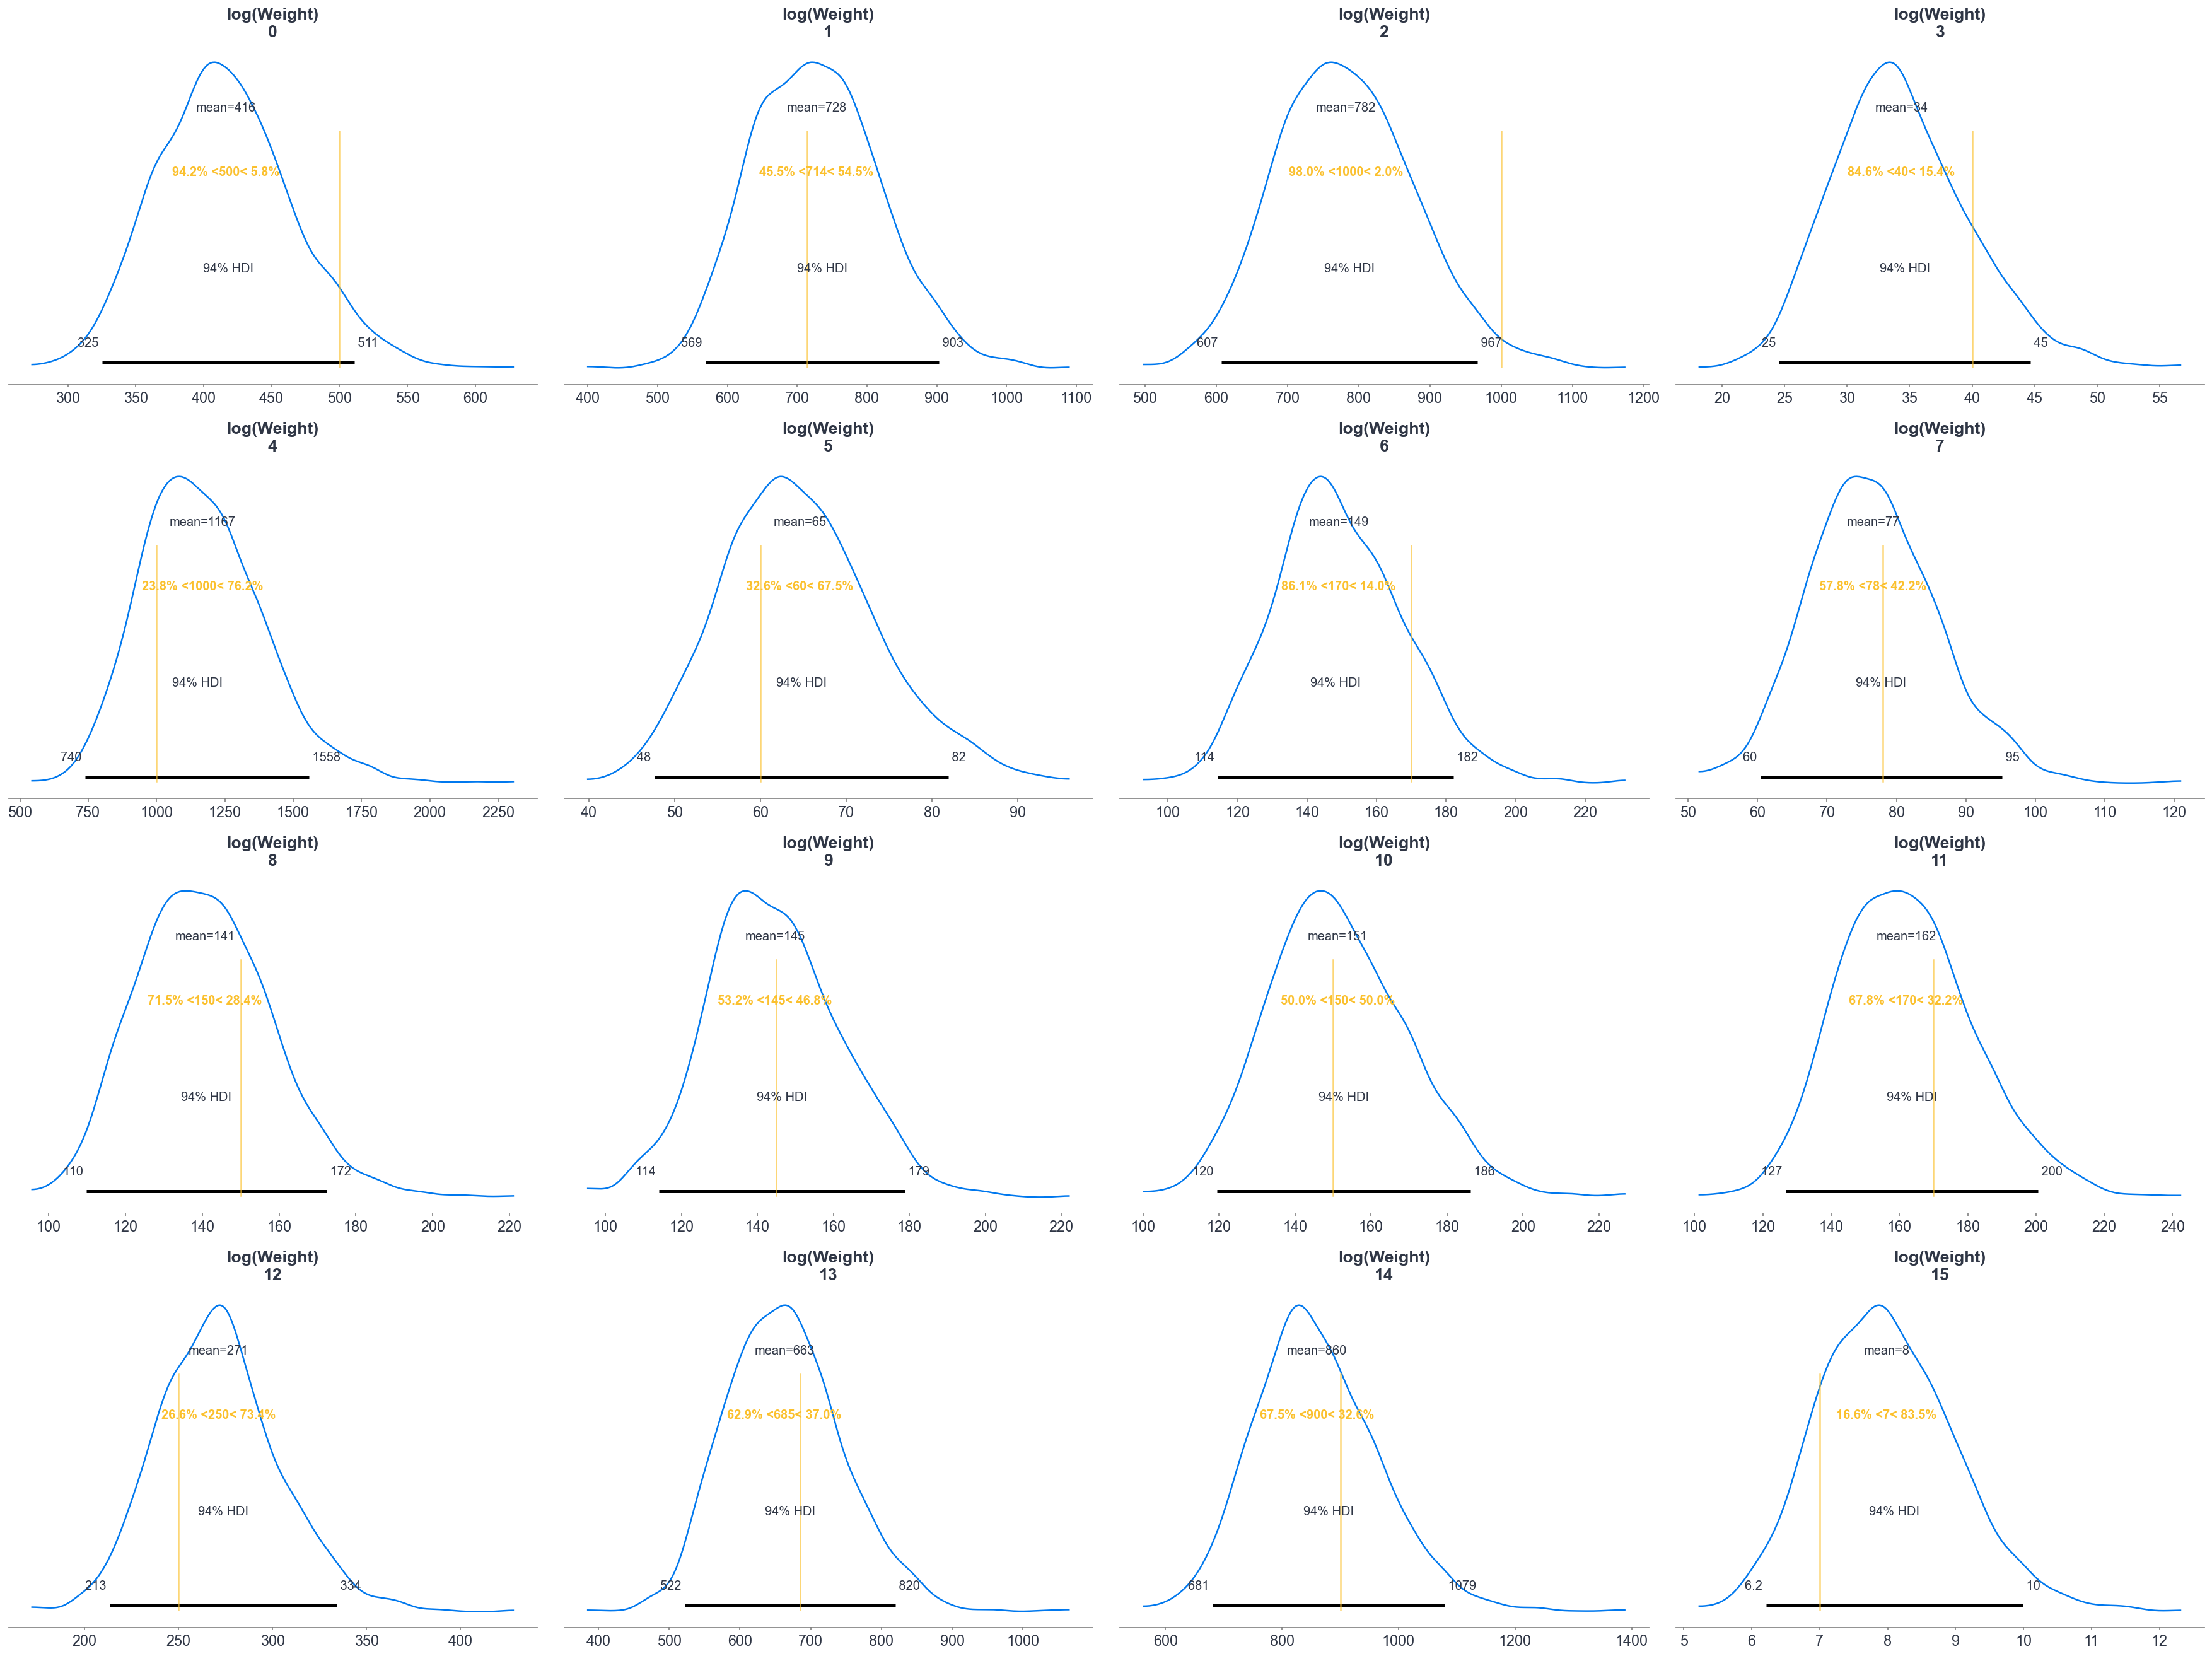

In [51]:
axes = az.plot_posterior(
    idata.posterior_predictive["log(Weight)"],
    ref_val=df_test["Weight"].tolist(),
    transform=np.exp,
)
plt.tight_layout()

* It's simply about using `az.plot_posterior()`.
    * Notice we pass the `log(Weight)` variable from the `.posterior_predictive` group
    * And still use the `transform=np.exp` because we modelled the log-transformed data
* The same results we got with PyMC!
    * But much easier

## Section Recap

* You don't need to worry about encoding details when computing predictions
    * Bambi handles all of them
* Get the same results than with PyMC
    * But much faster, with a small fraction of the work

## Section 100: End to end analysis with Bambi

You've now a matter of fitting things, with straight lines at least. In the next lessons we're going to move past straight lines, but before we get there lets do one last lap through the whole workflow with everything we learned, real quickly. In the future when youre trying to remmeber howt o fit regression fast, this will be the whole video you need. 

* Model specification
* Explore priors
* Explore prior predictive distribution
* Change priors?
* Update model
* Explore model again
* Fit model
* Explore posteriors
* Diagnose posteriors
* Show fitted curve
* Predict weigth for new observations

## Model specification

In [52]:
model = bmb.Model("log(Weight) ~ 0 + Species + log(Length1):Species", data)
model

Formula: log(Weight) ~ 0 + Species + log(Length1):Species
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Species ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0.], sigma: [ 7.9585 12.9856  6.9091 10.6655 10.1609 11.6298 17.2909])
    log(Length1):Species ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0.], sigma: [2.3359 4.4457 2.146  2.856  3.3612 4.8095 5.1616])

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1.322)

## Explore priors

In [53]:
model.plot_priors()

ValueError: Cannot plot priors until model is built!! Call .build() to build the model or .fit() to build and sample from the posterior.

* Oh, we forgot to build the model!
* Bambi also has friendly error messages ;)

## First, build the model, then plot priors

In [54]:
model.build()

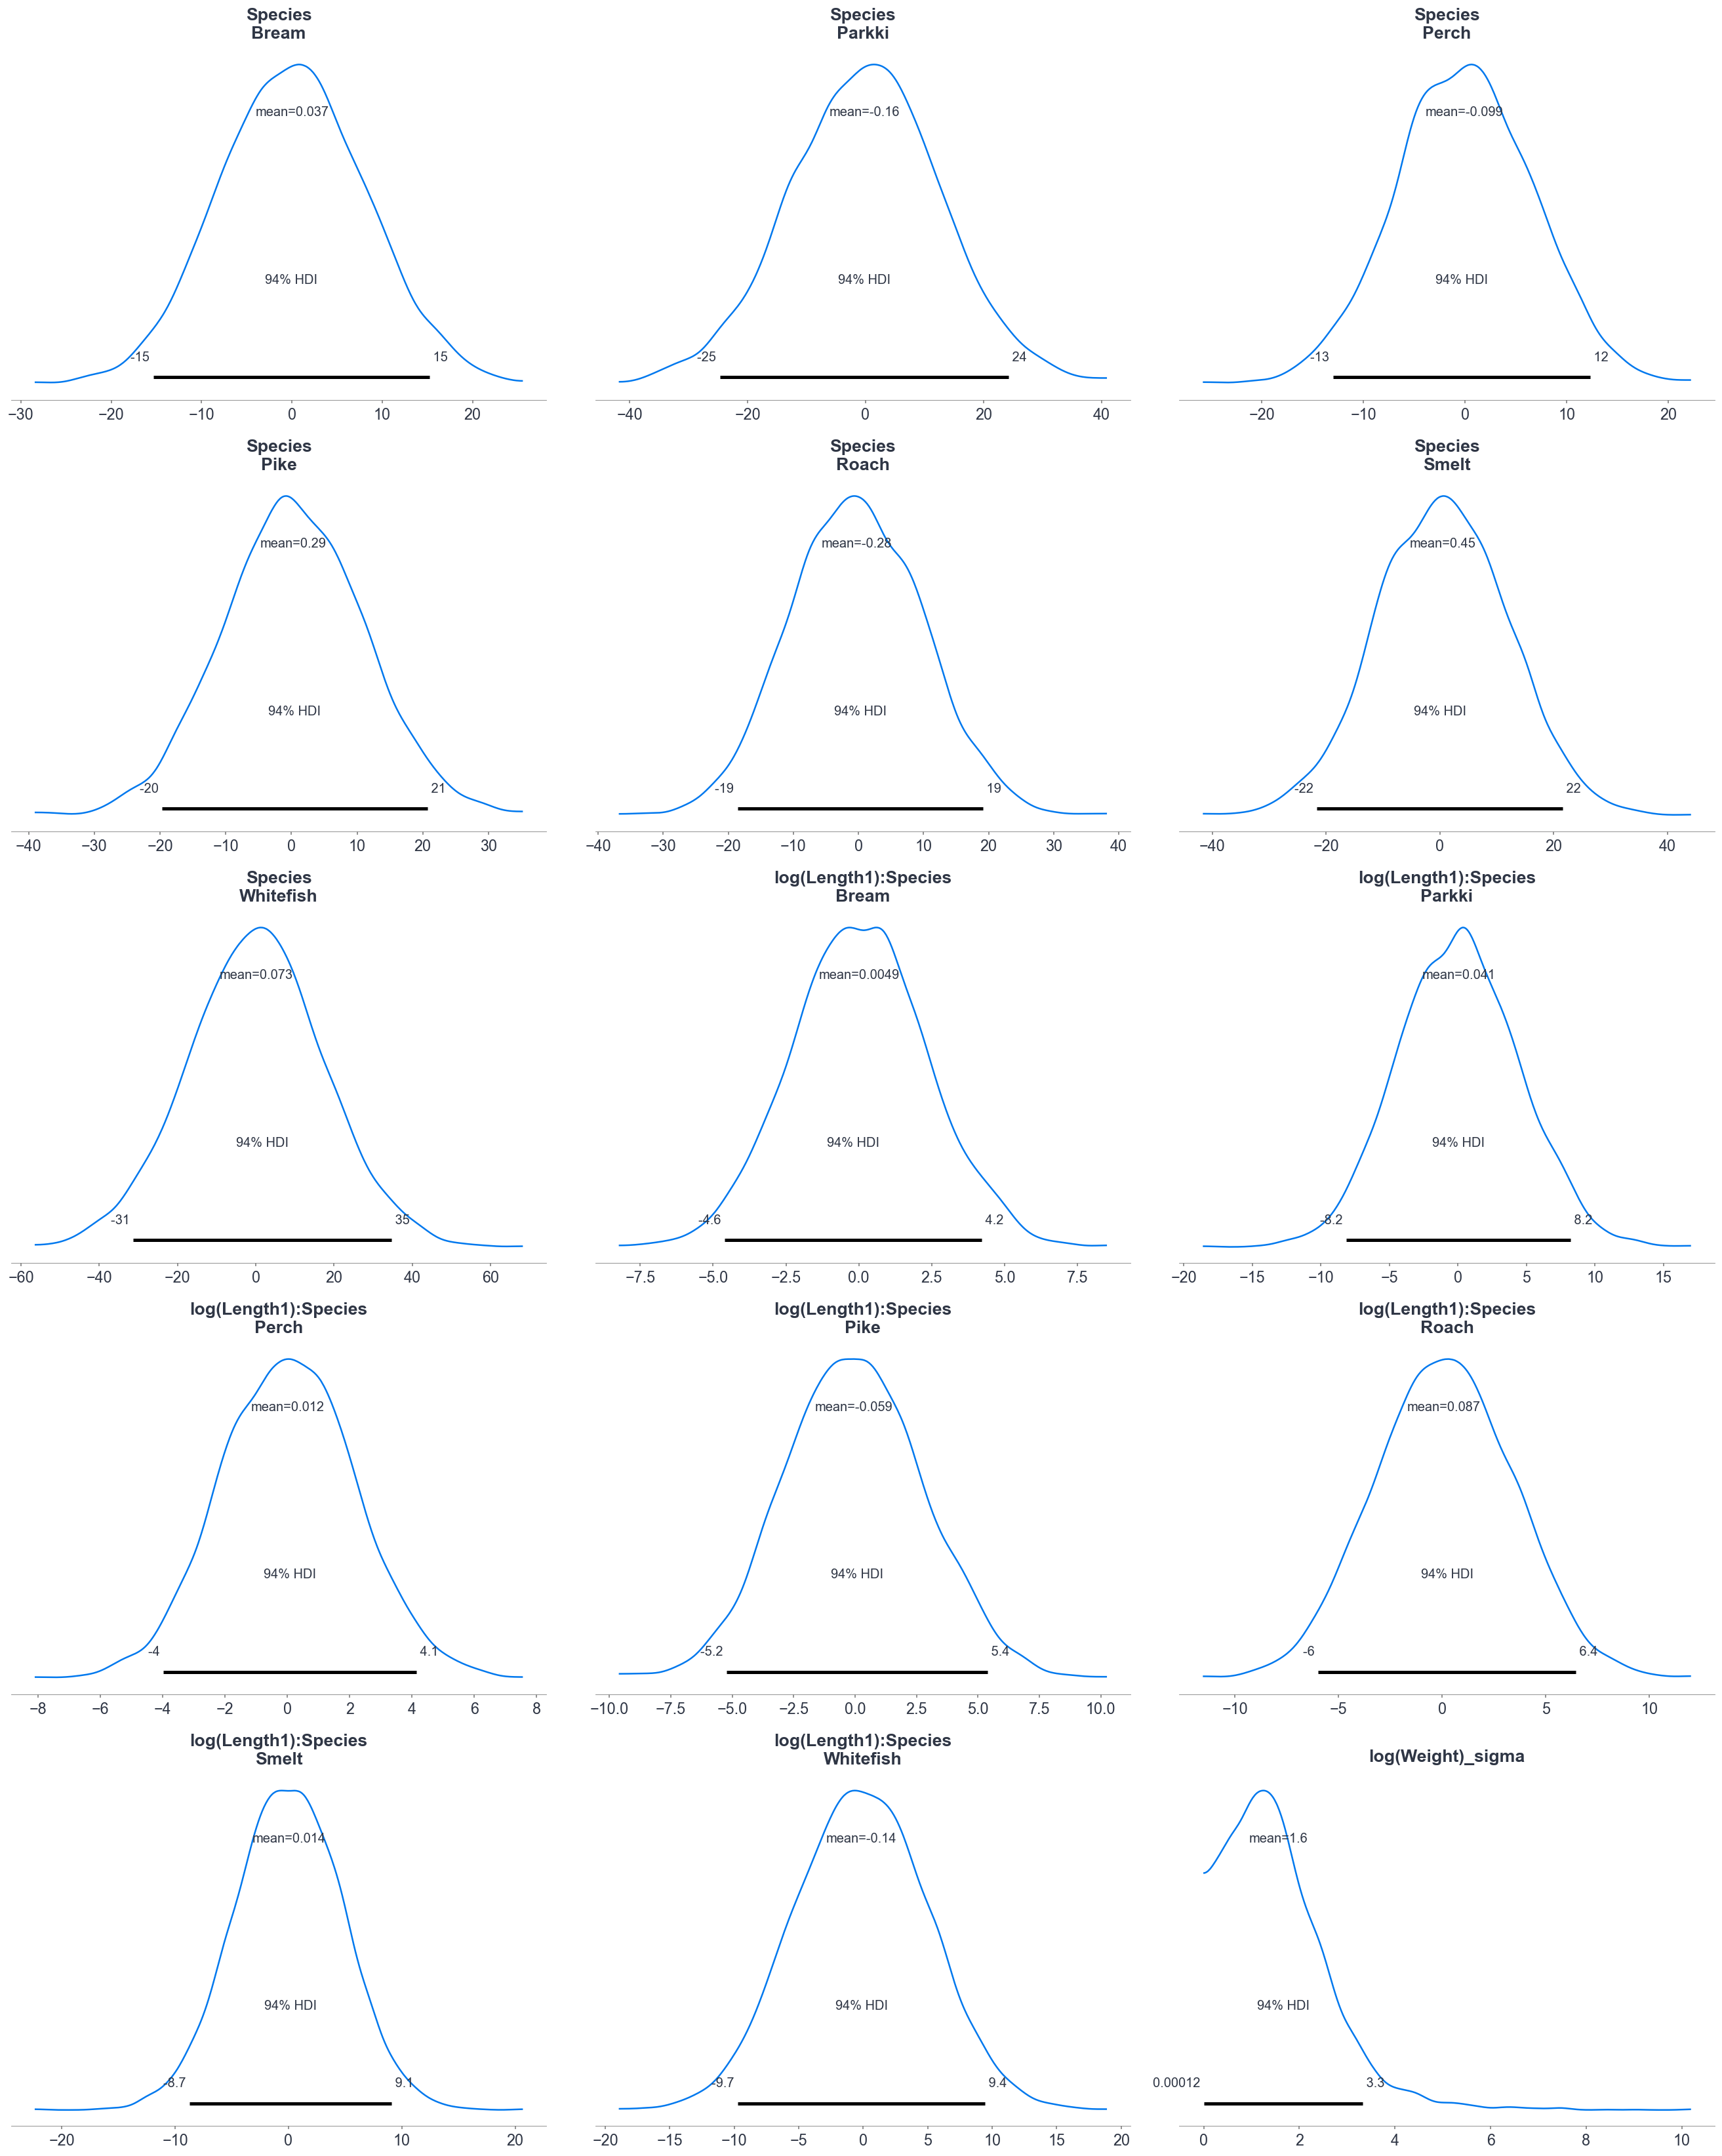

In [55]:
model.plot_priors();
plt.tight_layout()

* The plot above is fine, but so many panels are not easy to process all at once
* It's hard to say if the priors are too wide or too tight

## Prior predictive distribution

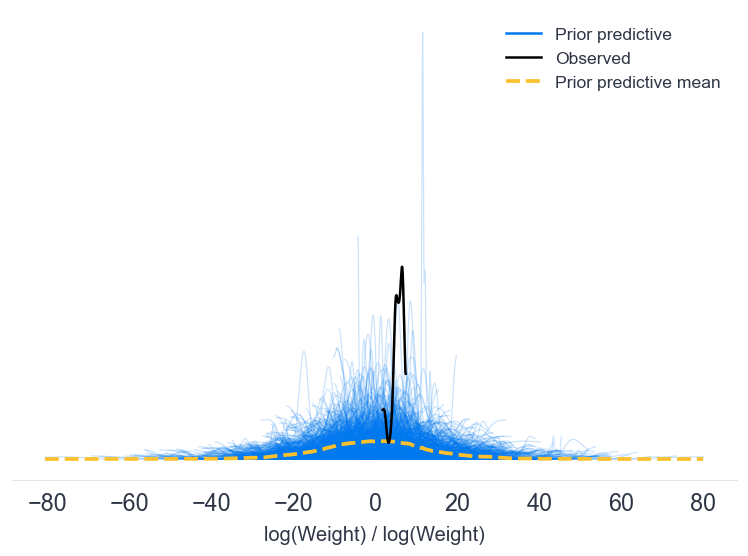

In [56]:
prior_predictive = model.prior_predictive()
az.plot_ppc(prior_predictive, group="prior");
plt.tight_layout()

* Perhaps too wide?

## Update priors

In [57]:
species_prior = bmb.Prior("Normal", mu=0, sigma=1.5)
slopes_prior = bmb.Prior("Normal", mu=0, sigma=1.5)
sigma_prior = bmb.Prior("HalfNormal", sigma=1)
priors = {"Species": species_prior, "log(Length1):Species": slopes_prior, "sigma": sigma_prior}
model.set_priors(priors)

In [58]:
model

Formula: log(Weight) ~ 0 + Species + log(Length1):Species
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Species ~ Normal(mu: 0, sigma: 1.5)
    log(Length1):Species ~ Normal(mu: 0, sigma: 1.5)

  Auxiliary parameters
    sigma ~ HalfNormal(sigma: 1)

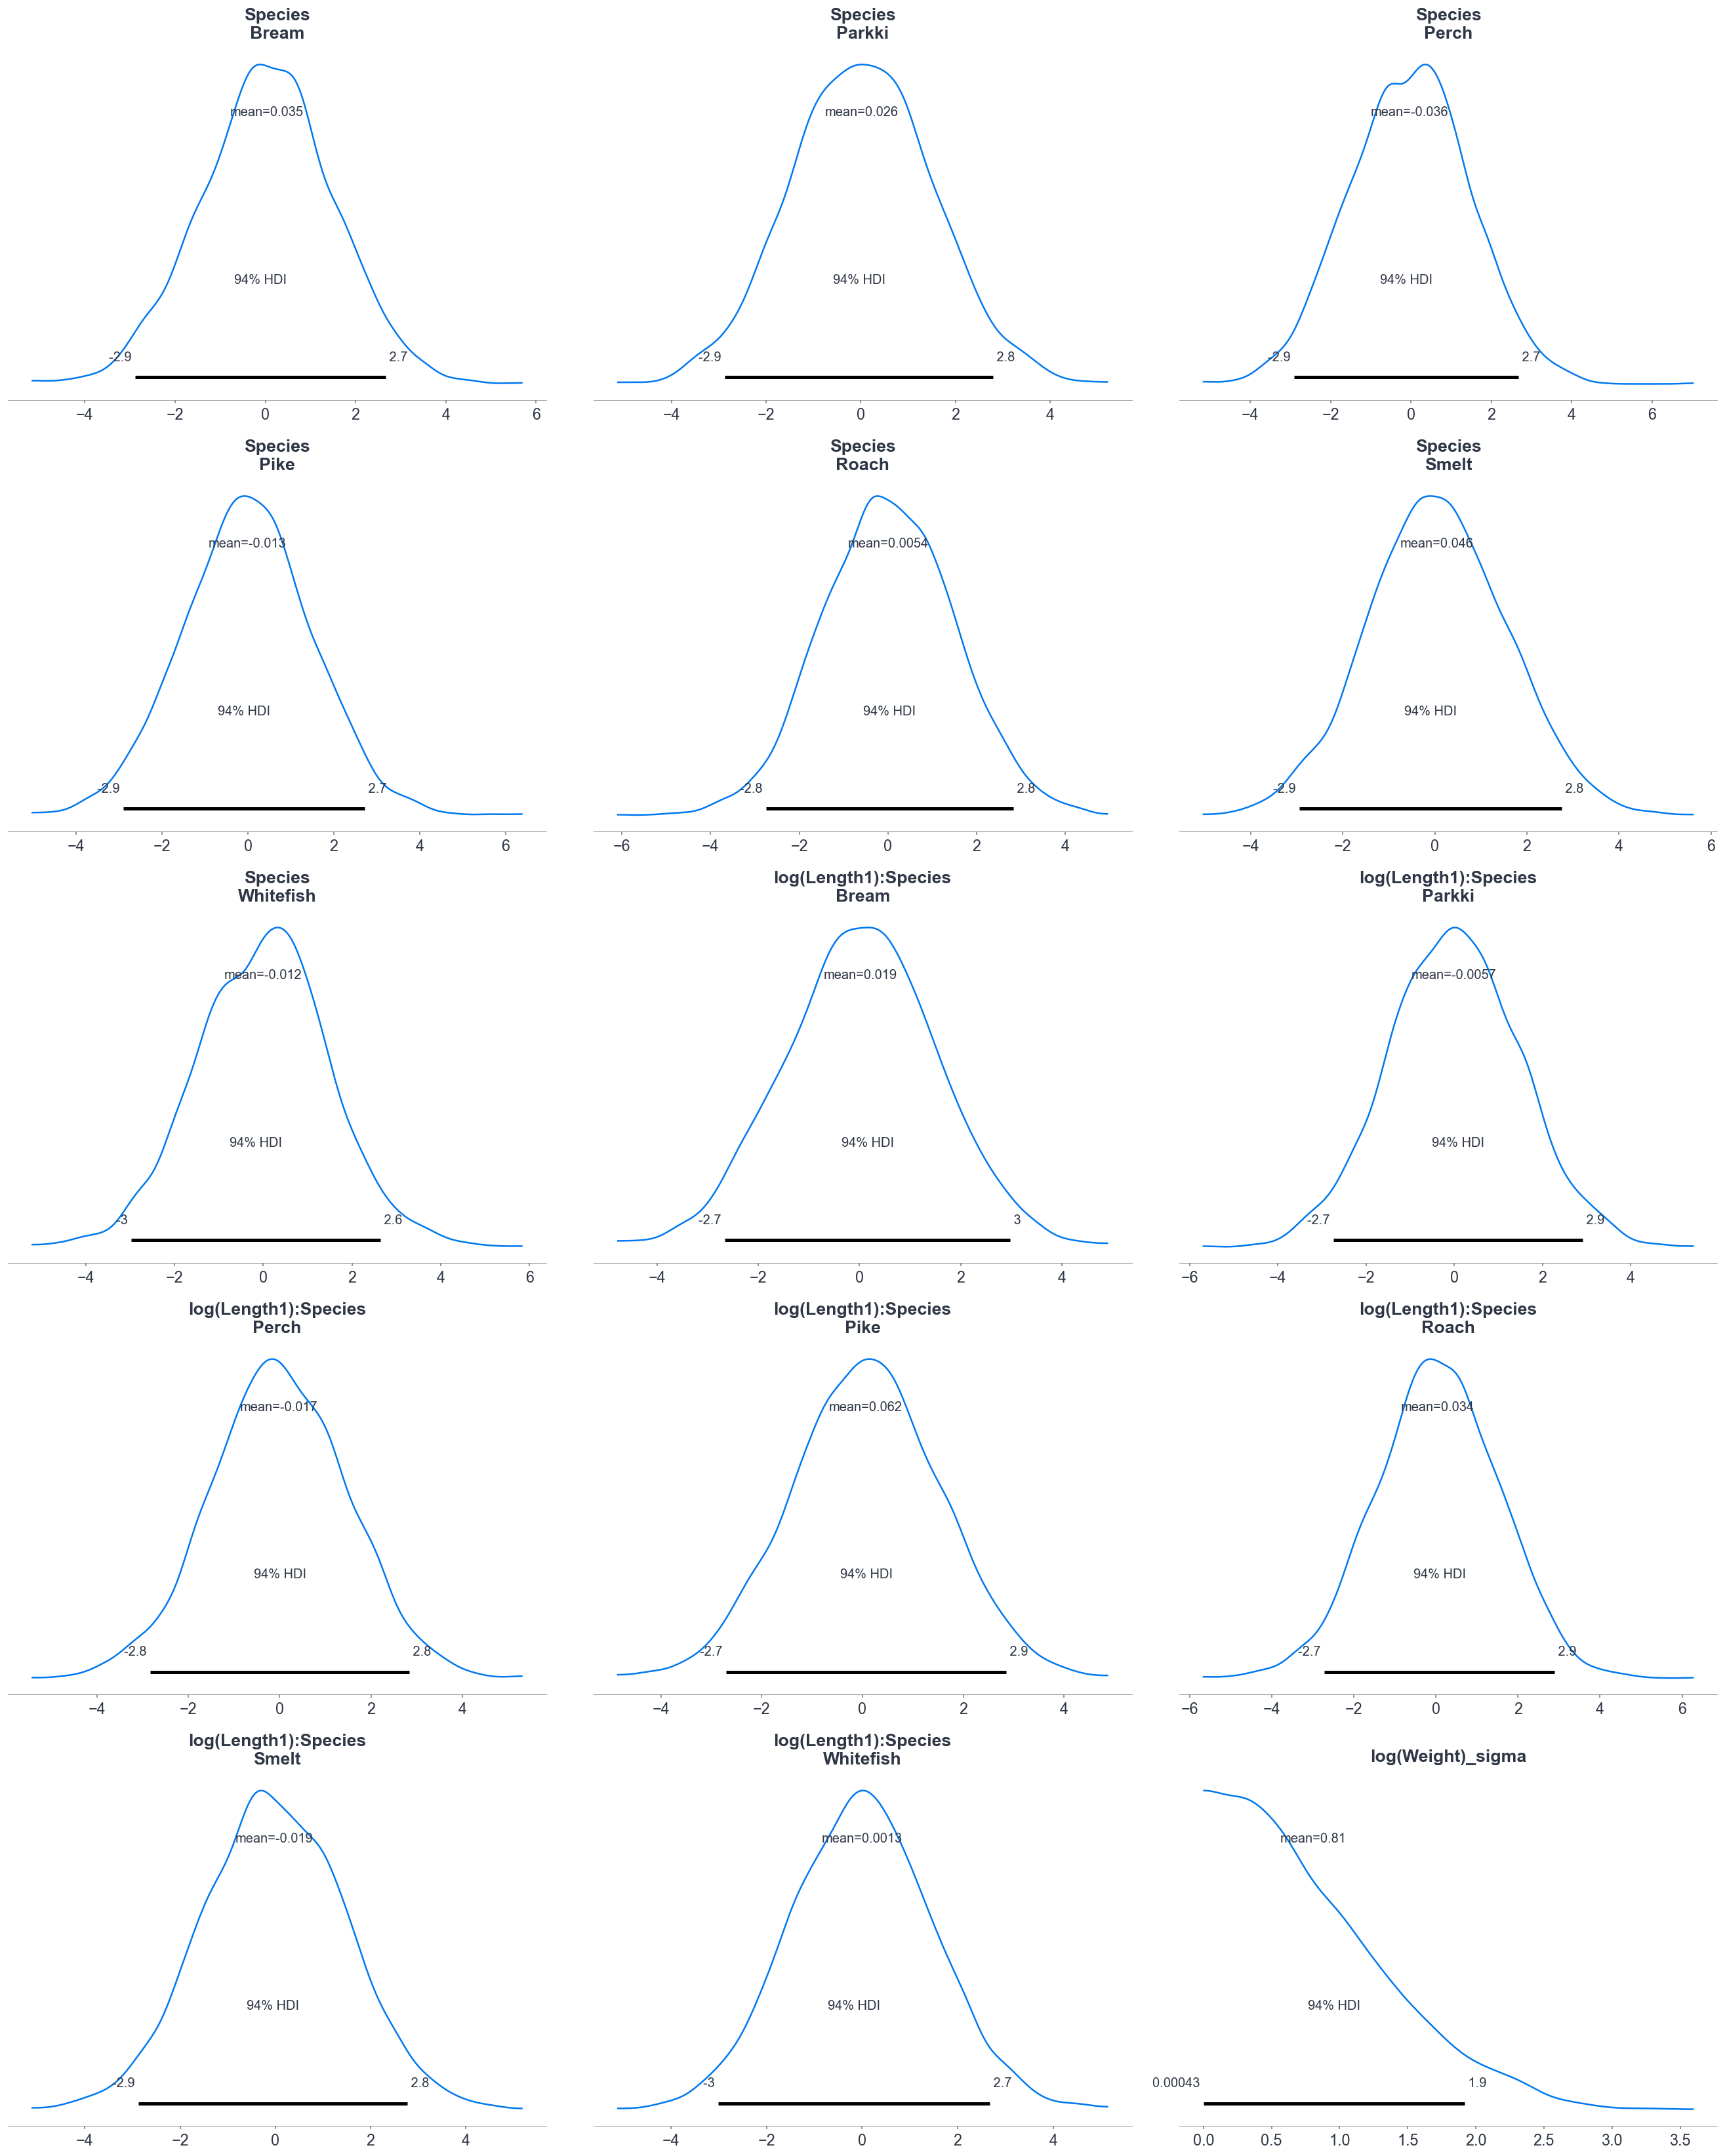

In [59]:
model.build()
model.plot_priors();
plt.tight_layout()

## Prior predictive checks again

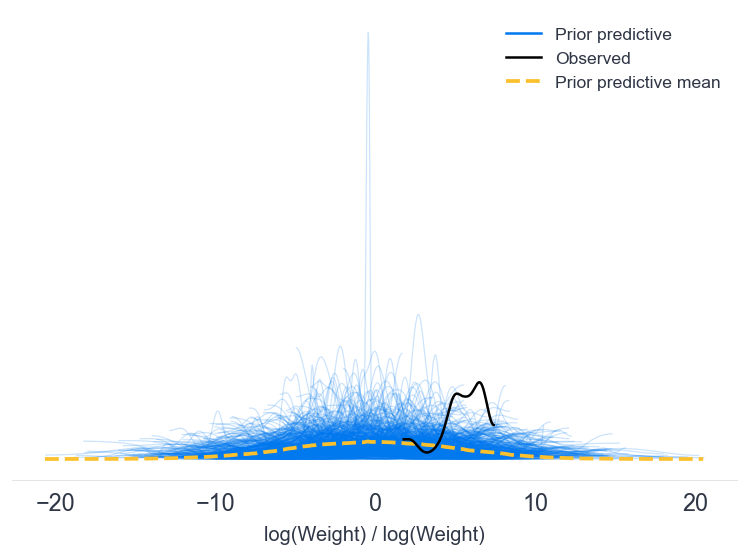

In [60]:
prior_predictive = model.prior_predictive()
az.plot_ppc(prior_predictive, group="prior");
plt.tight_layout()

## Fit the model

In [61]:
idata = model.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Species, log(Length1):Species, log(Weight)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.


## Explore the posterior

## Explore the posterior predictive distribution

## Explore the fitted curves

## Predictions again?

I'm not so sure about this

## Section Recap

# Lesson Recap

# Appendix: Priors in Bambi

## There are default priors

## How to access the actual priors

## How to specify priors when creating the model

## How to update priors in an existing model

## How to visualize priors

## Priors on auxiliary parameters

* `sigma` is not a predictor, but it's a parameter in the model
* That's why Bambi allows to set priors for `sigma`, the standard deviation of the error component in the Normal regression model

## Priors are a thin layer on top of PyMC distributions

This is why `bmb.Prior("Normal", mu=0, sigma=1)` worked for the `Species` term. 

Bambi creates a PyMC distribution, and it follows the same broadcasting rules.